# 캐글 경진대회, 무작정 따라해보기
## 집 값 예측하기
### - 목차
1. 데이터 준비 및 확인   
2. 데이터 전처리   
3. 모델링   
    3.1 LGBMRegressor 모델   
    3.2 XGBRegressor 모델     
    3.3 blending    
    3.4 stacking ensemble   
    3.5 xgb, lgbm ensemble   
4. 프로젝트 정리

---

# 1. 데이터 준비 및 확인

In [2]:
#필요한 모듈 설치

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
#data load

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
#train data 확인
print(train.shape)
train.head()

(15035, 21)


id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [5]:
#test data 확인
print(test.shape)
test.head()

(6468, 20)


id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

# 2. 데이터 전처리

- 결측치는 없었으므로 결측치에 대한 전처리는 하지 않음.
- 날짜 데이터는 문자가 포함되어 있기에 모두 숫자형으로 변경함.
- 이상치를 확인하기 위해 데이터를 시각화함. 시각화 결과 몇개의 칼럼에서 이상치가 있다고 판단하여 이상치를 제거함.
- 데이터 분석에 있어 불필요하다고 생각한 'id' 칼럼 삭제함.
- target인 price 데이터를 시각화 했을 때 한 쪽으로 치우져 있어 로그변환을 함.
- price 외의 다른 데이터 또한 시각화 했을 때 한 쪽으로 치우쳐 있는 데이터가 있어 해당 데이터들을 정규화 시킴.

In [6]:
#train data 결측치 확인
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

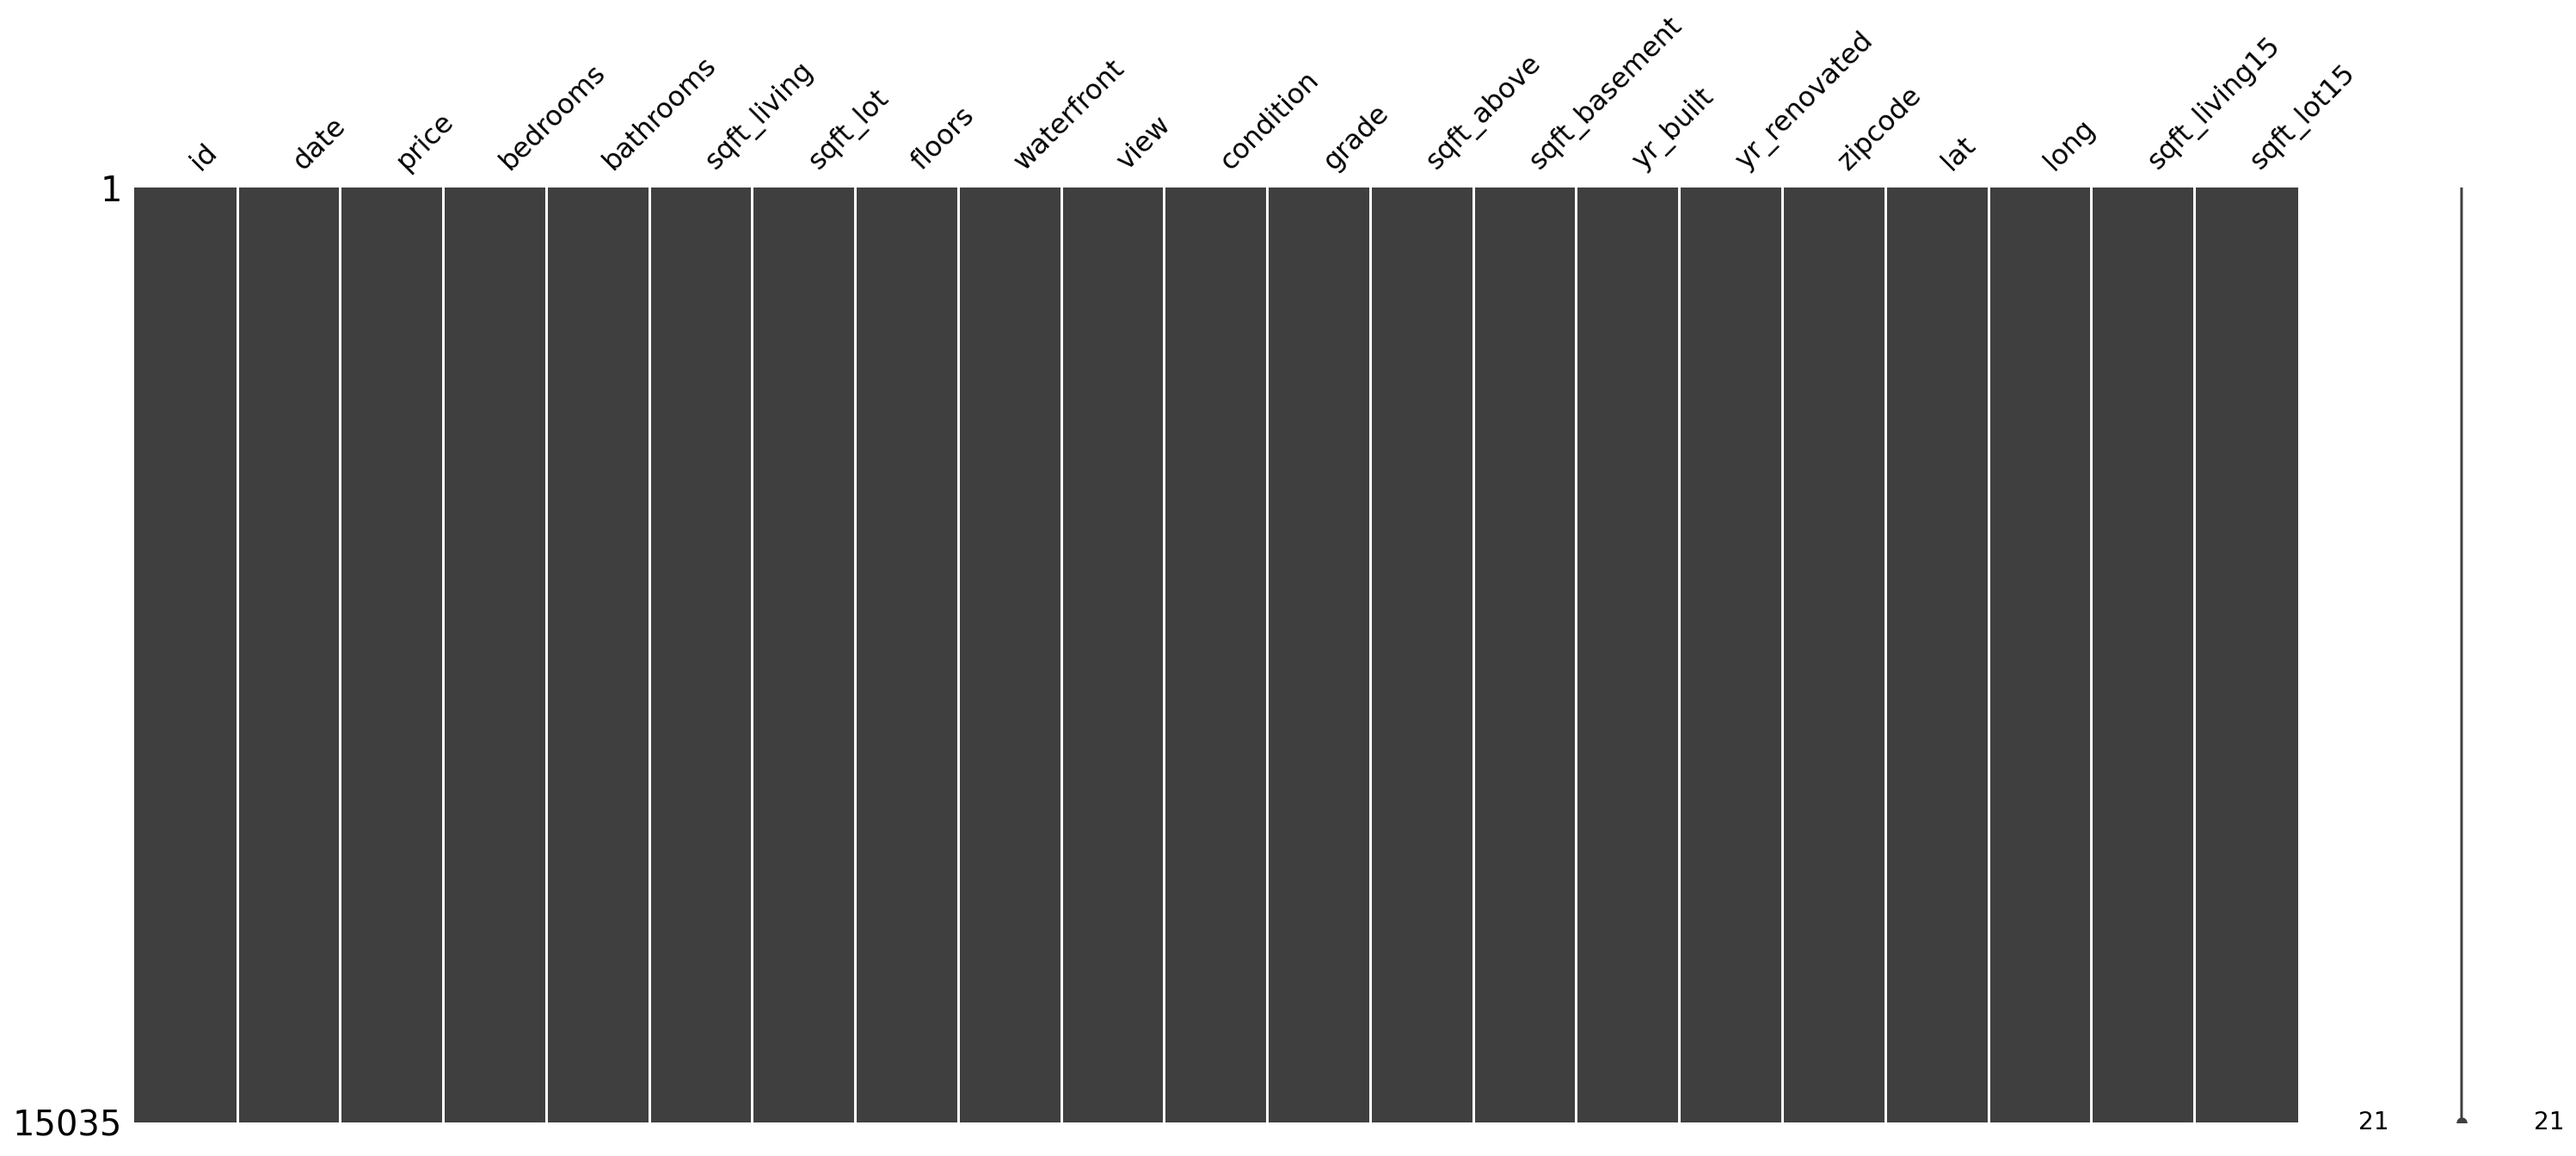

In [9]:
msno.matrix(train)

In [8]:
#test data 결측치 확인
test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

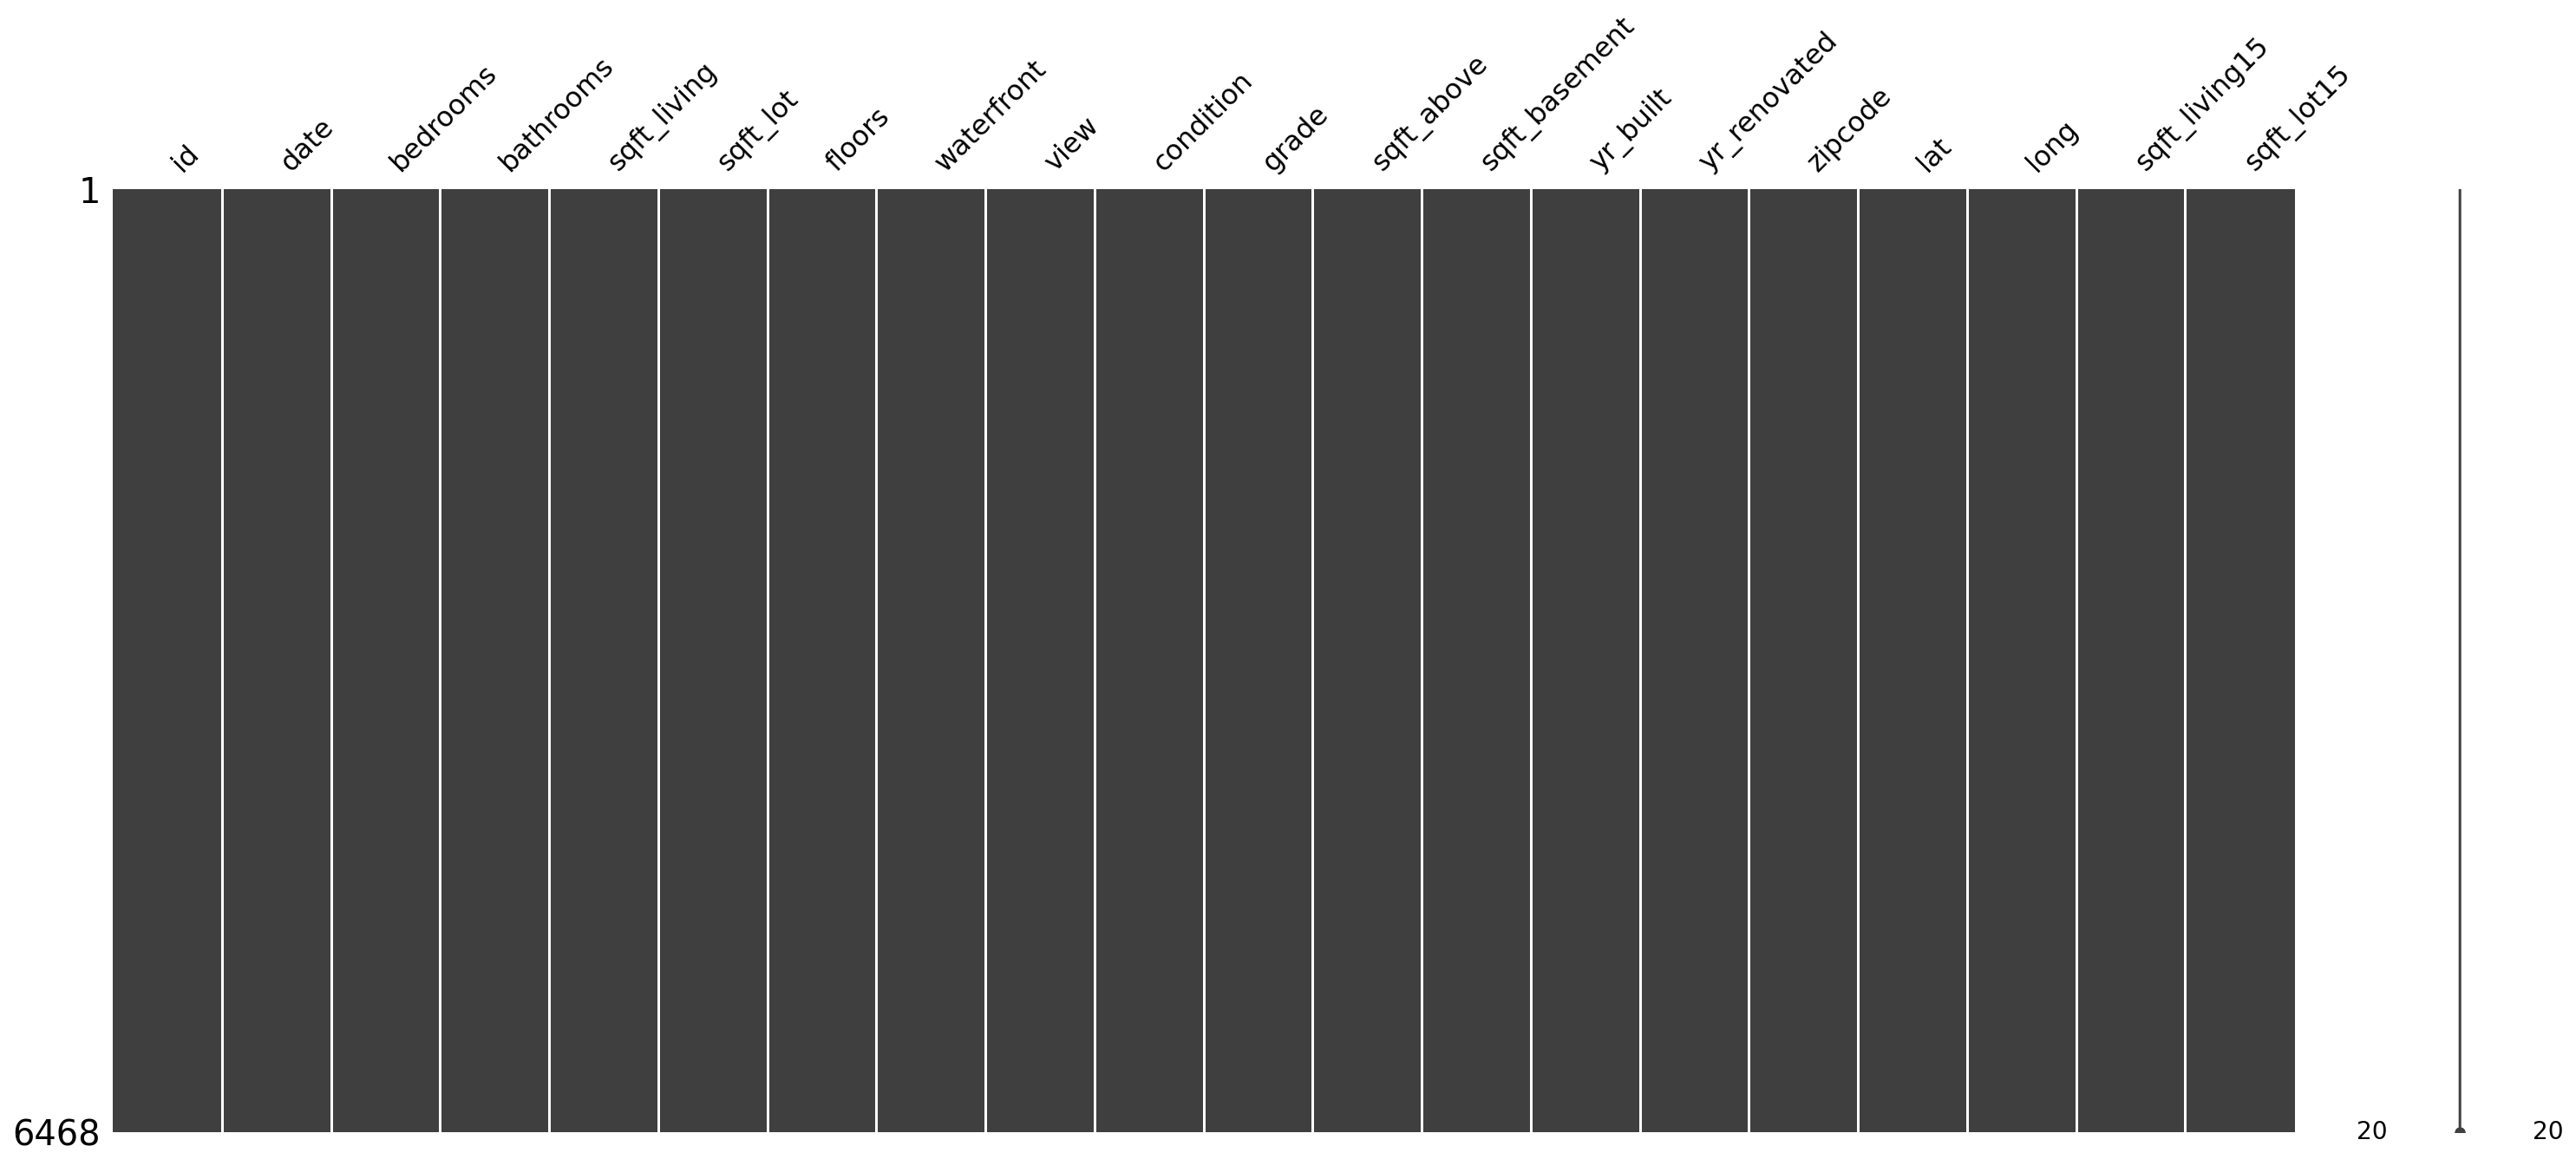

In [10]:
msno.matrix(test)

In [13]:
#문자가 포함된 date를 정수형으로 변환

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [14]:
#test data 역시 문자가 포함된 date를 정수형으로 변환

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  201412         3       2.25         2570      7242     2.0   
1  15036  201412         4       3.00         1960      5000     1.0   
2  15037  201405         4       4.50         5420    101930     1.0   
3  15038  201504         3       1.00         1780      7470     1.0   
4  15039  201503         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


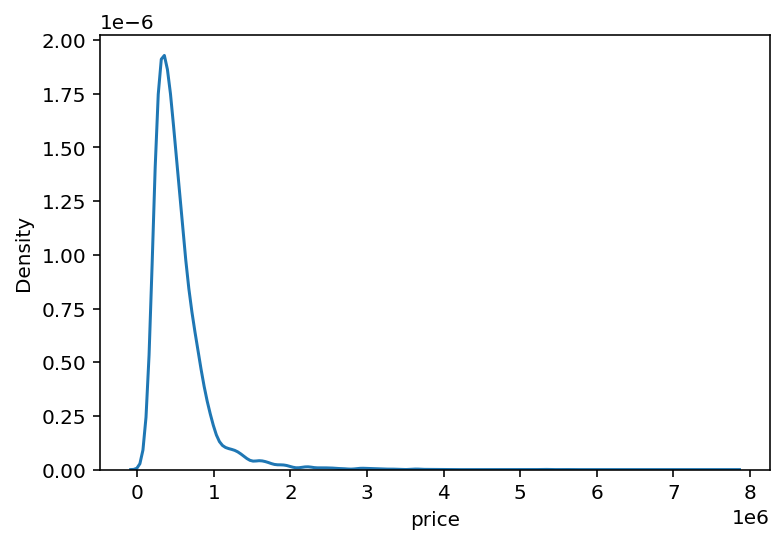

In [15]:
#target인 price 데이터 확인

print(train['price'])

sns.kdeplot(train['price'])
plt.show()

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


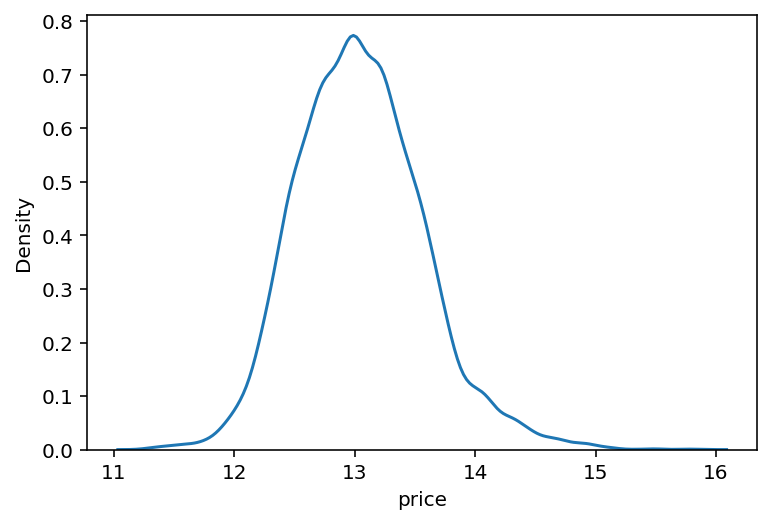

In [16]:
train['price'] = np.log1p(train['price'])
print(train['price'])

sns.kdeplot(train['price'])
plt.show()

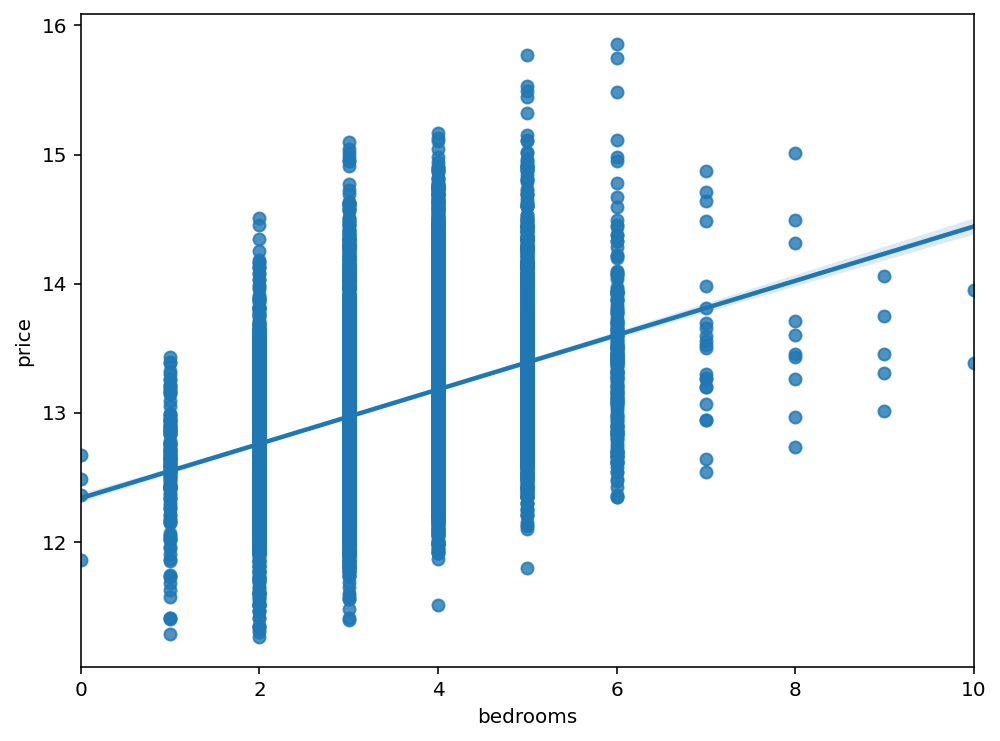

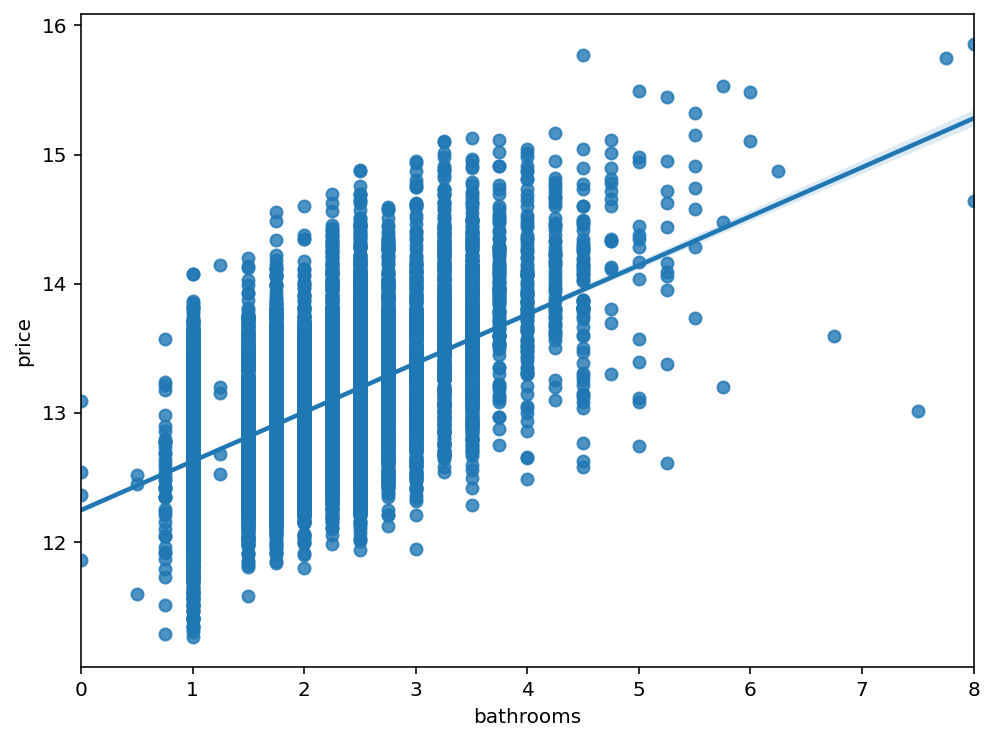

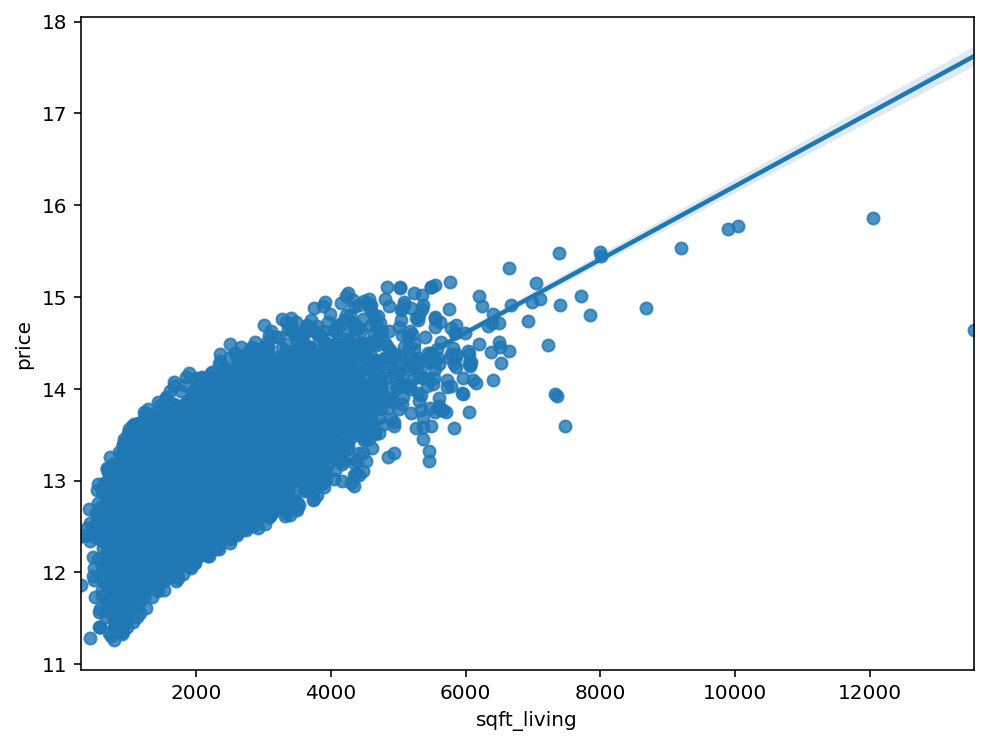

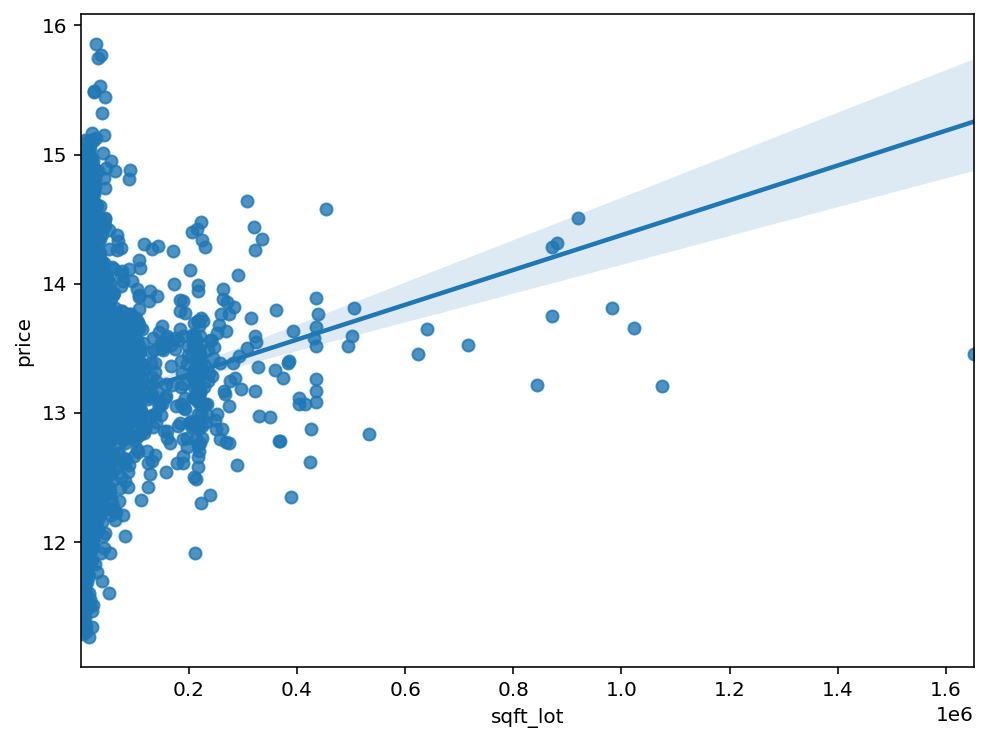

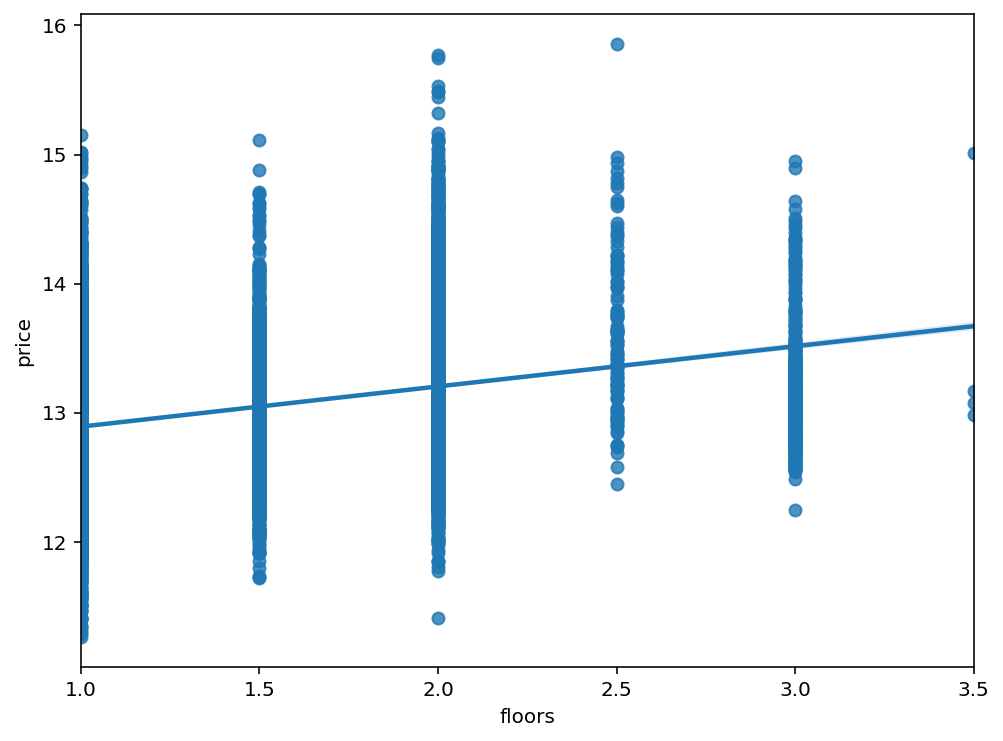

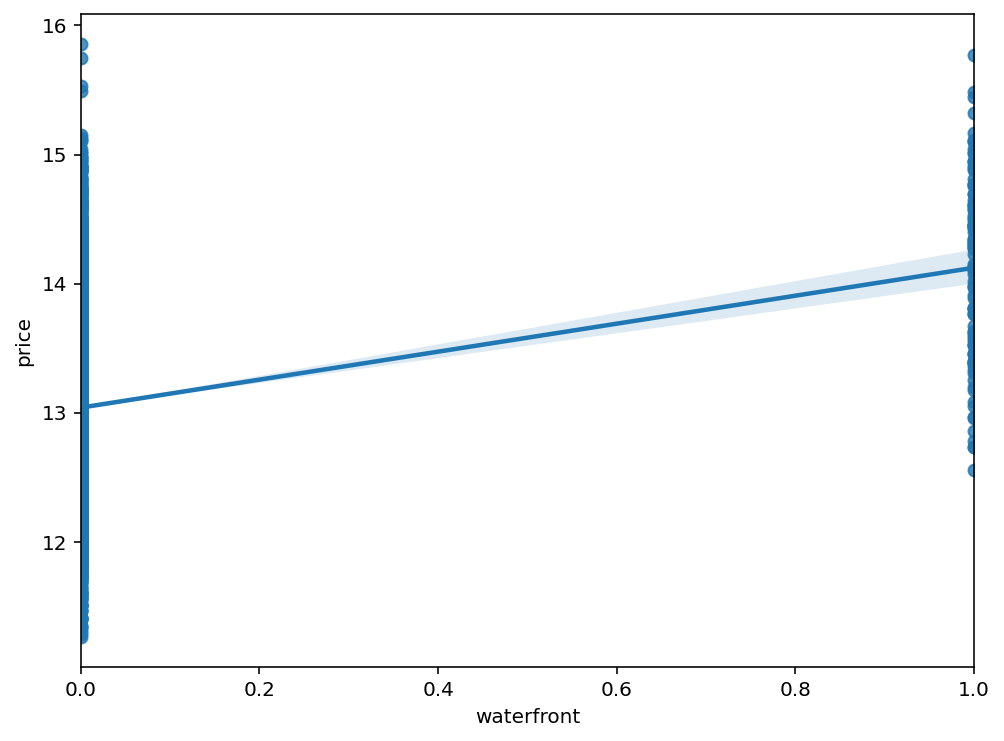

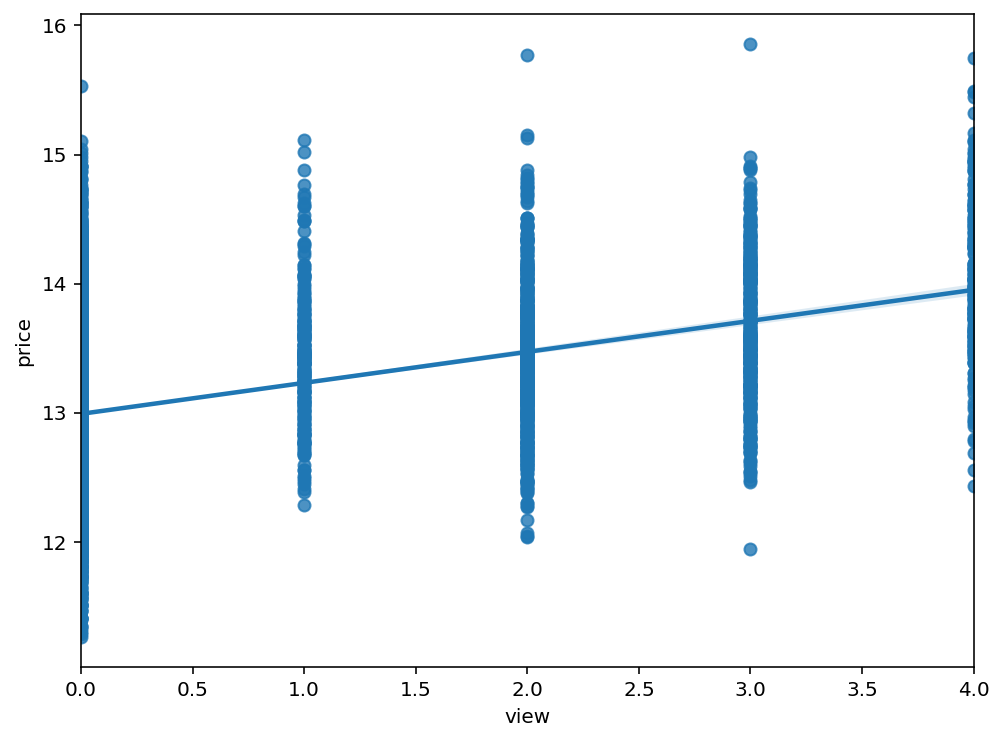

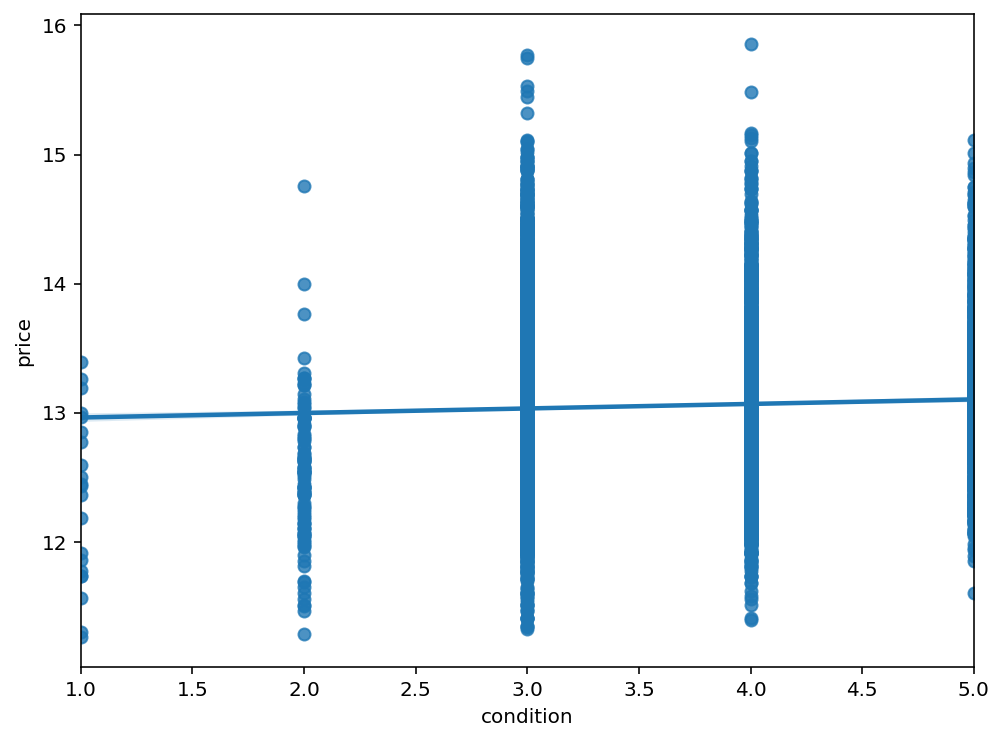

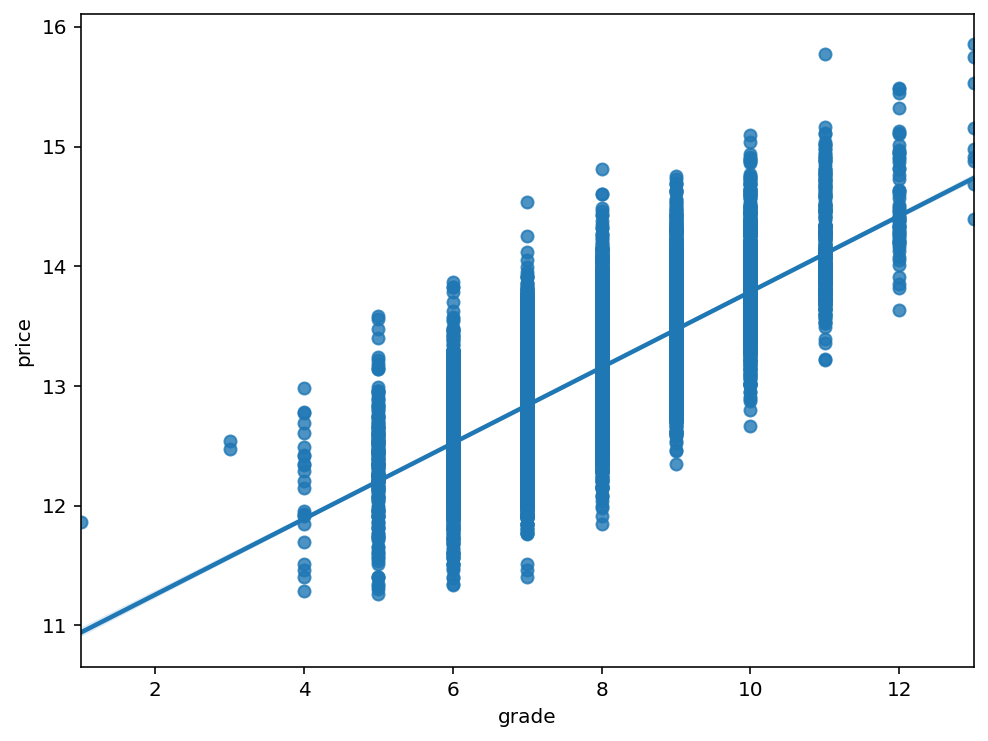

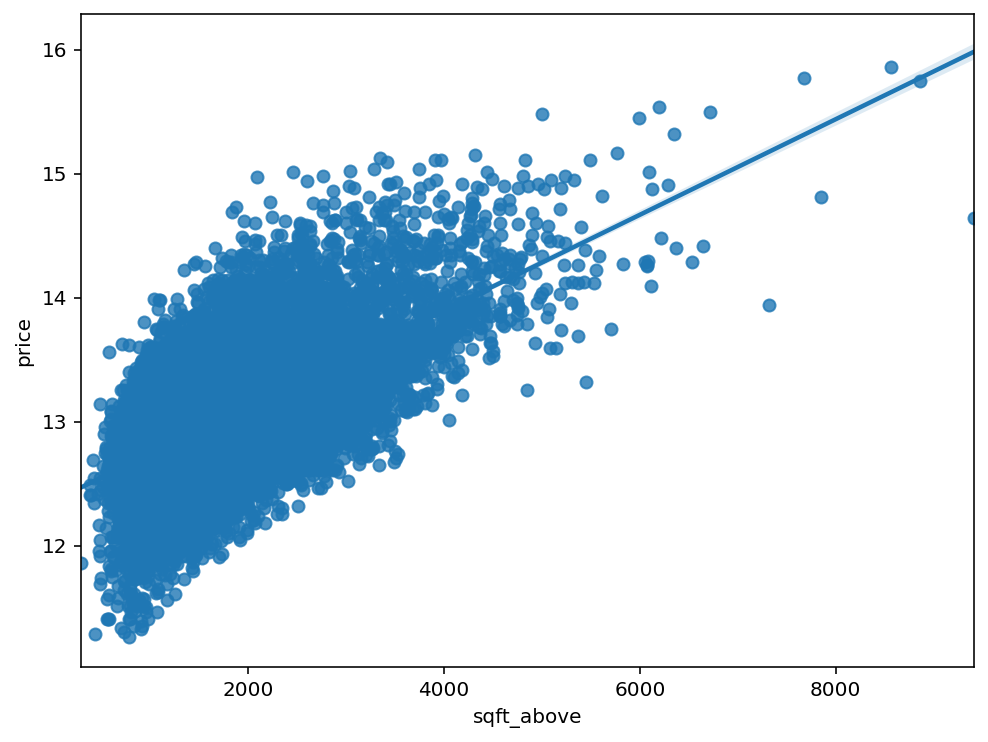

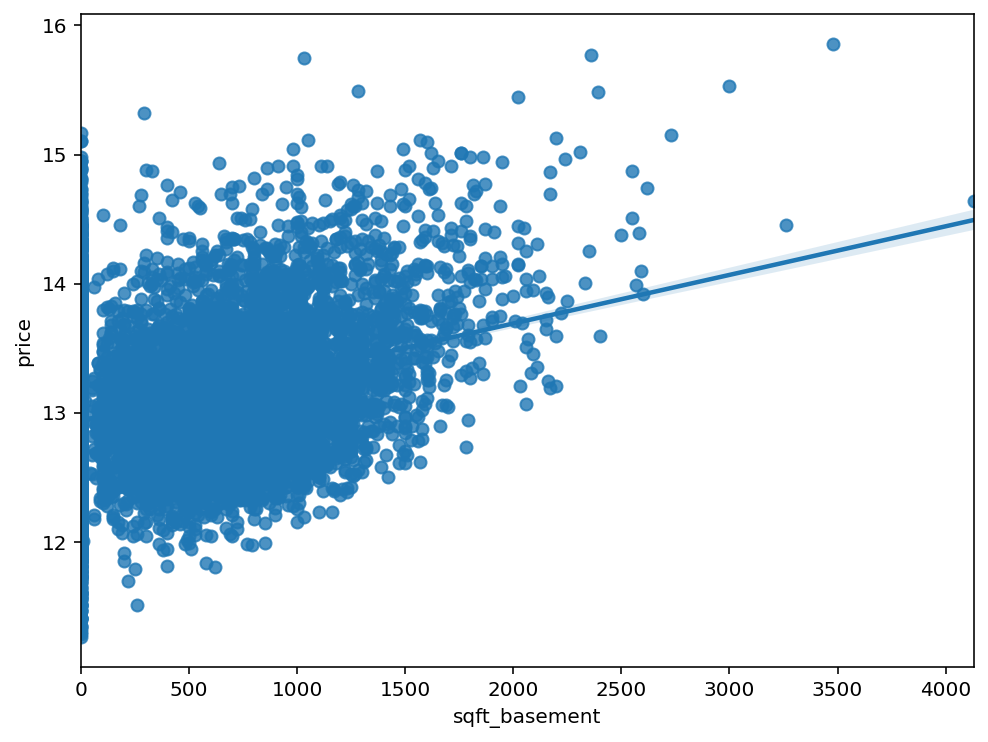

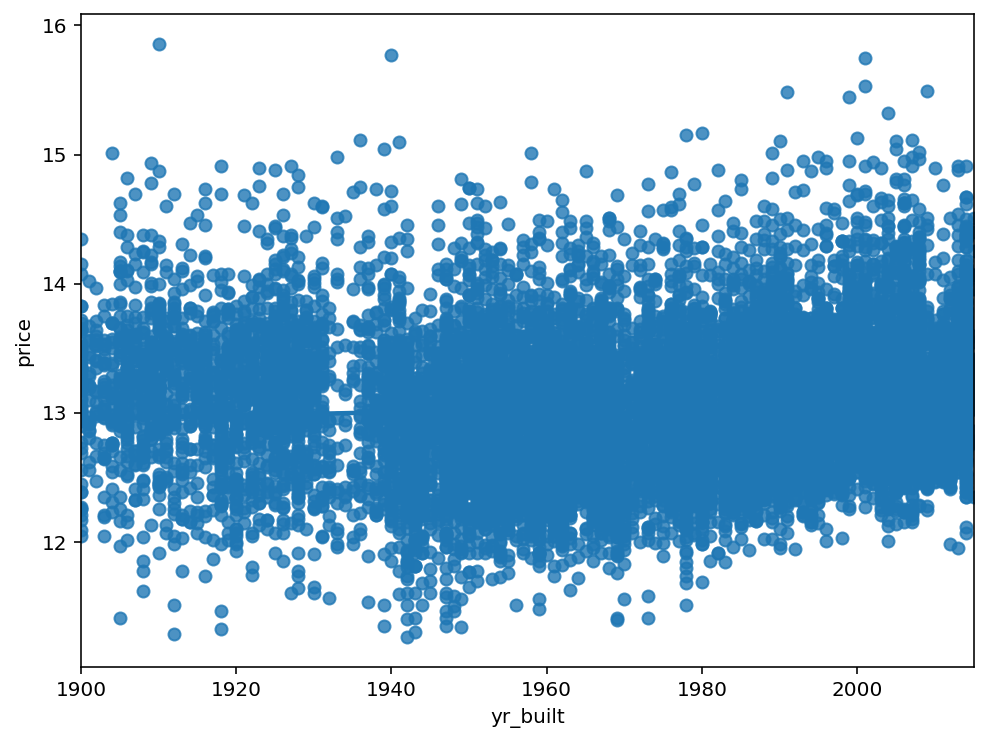

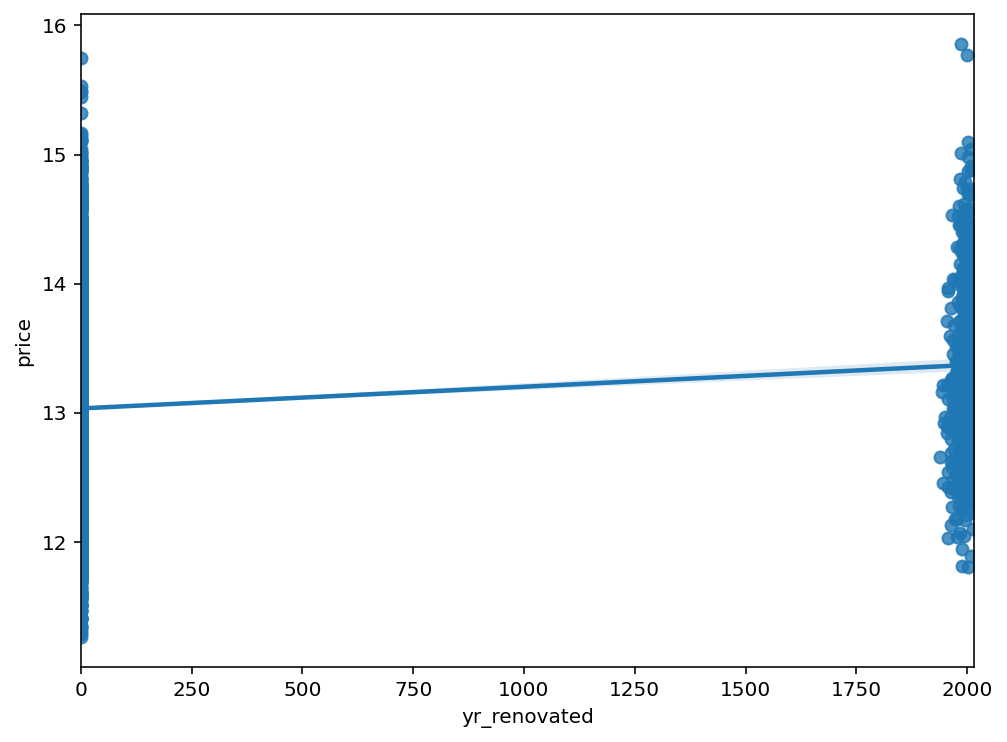

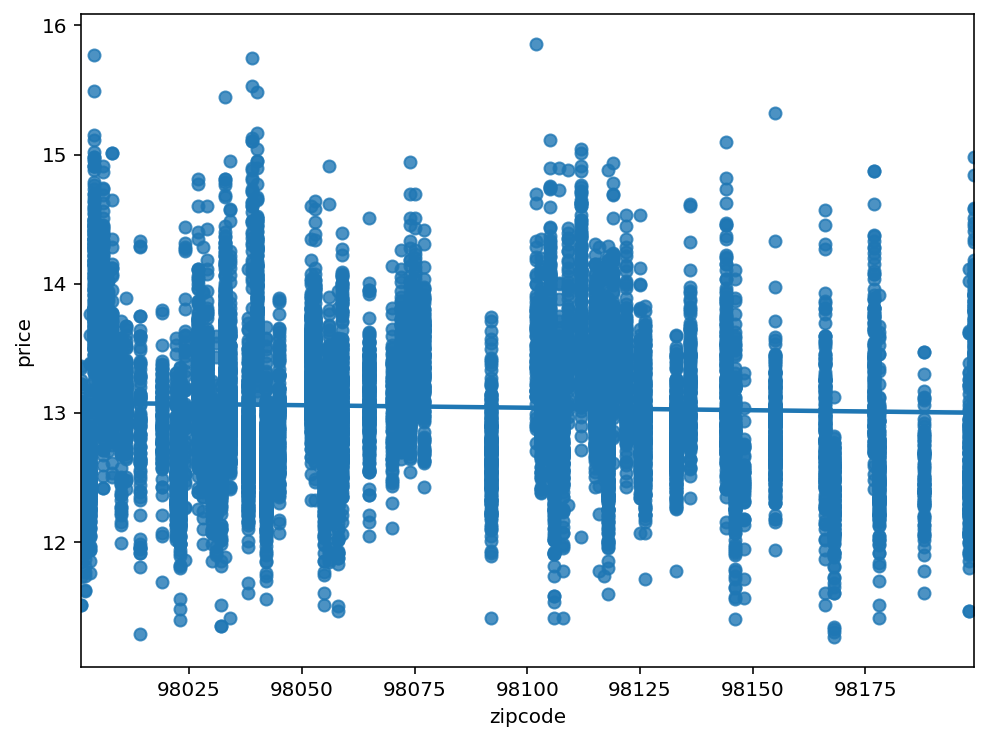

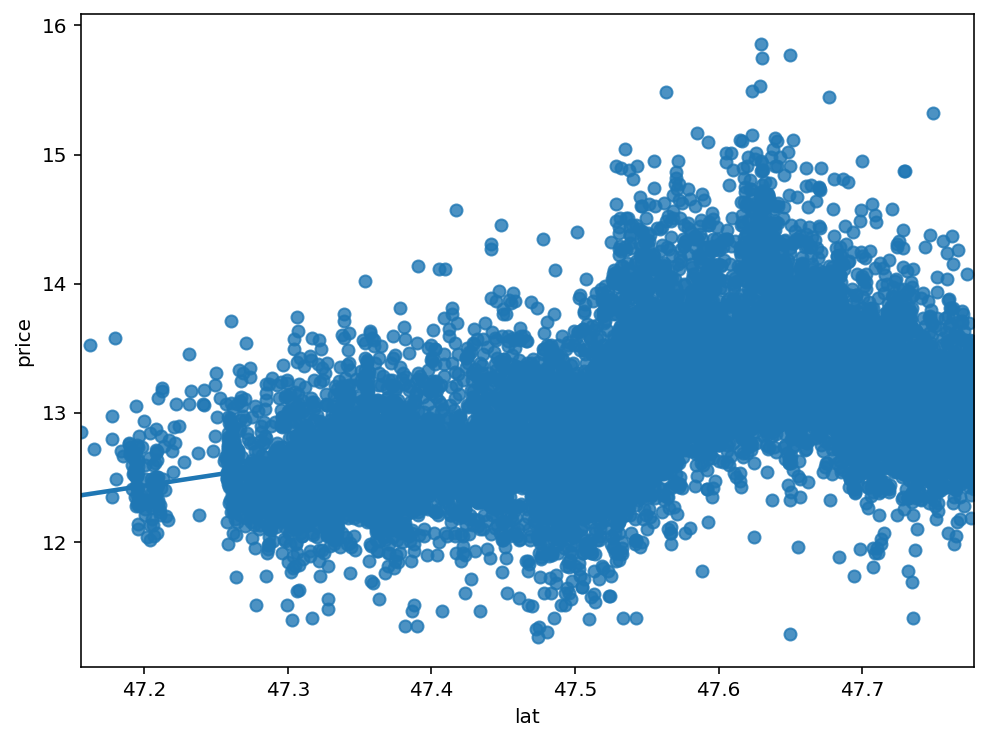

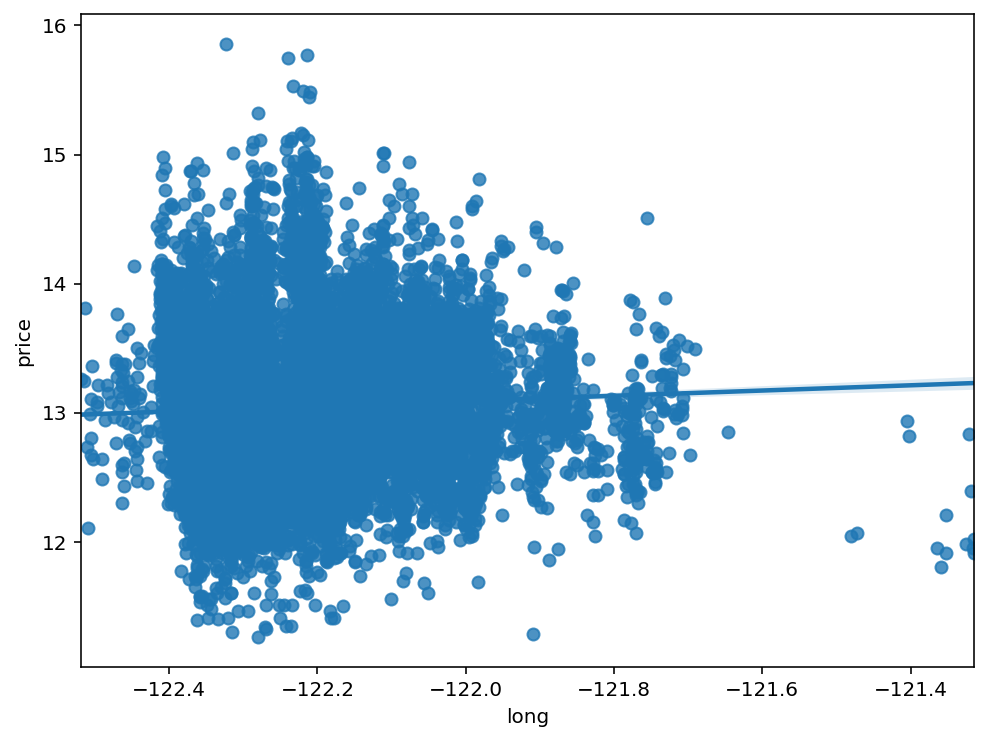

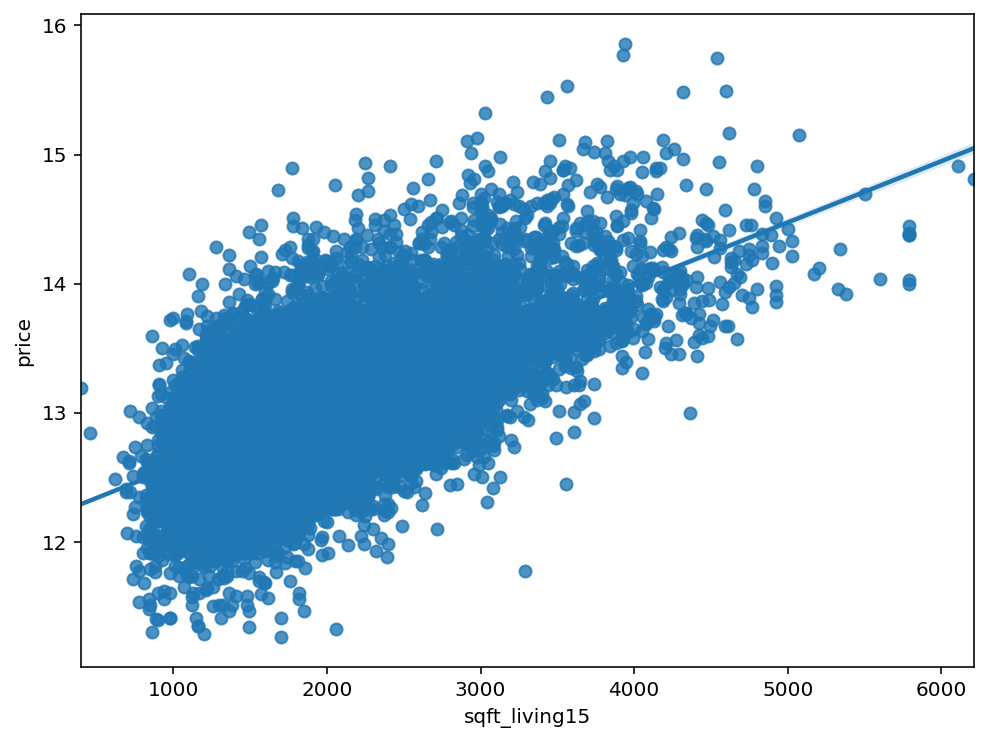

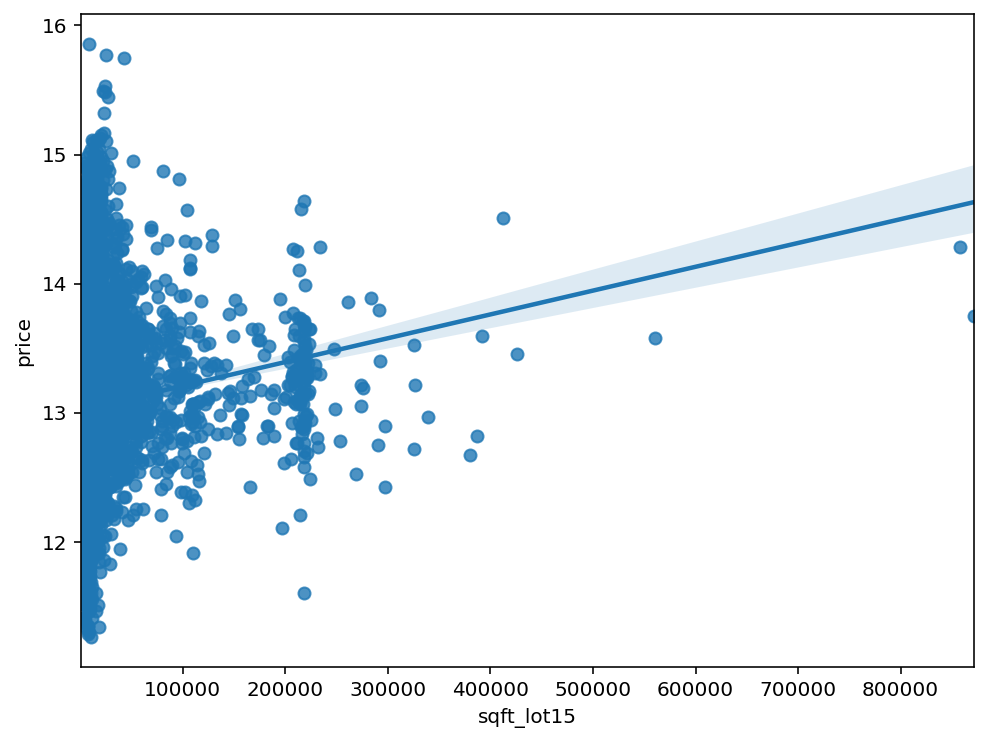

In [17]:
#이상치 확인

count = 3
columns = train.columns
for row in range(9):
    for col in range(2) :
        data = pd.concat([train['price'], train[columns[count]]], axis = 1)
        f, ax = plt.subplots(figsize=(8,6))
        fig = sns.regplot(x=columns[count], y="price", data=data)
        count += 1
        if count == 19 :
            break

- sqft_living에서 혼자 큰 값을 가진 데이터가 있어 이상치라고 판단.
- grade 역시 이상치가 있다고 판단.

In [18]:
#sqft_living 이상치 확인
train.loc[train['sqft_living'] > 13000]

id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
8912  8912  201405  14.639686         7        8.0        13540    307752   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
8912     3.0           0     4  ...     12        9410           4130   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
8912      1999             0    98053  47.6675 -121.986           4850   

      sqft_lot15  
8912      217800  

[1 rows x 21 columns]

In [19]:
#sqft_living 이상치 제거
train = train.loc[train['id']!=8912]

In [20]:
#grade 이상치 확인
train.loc[(train['price']>12) & (train['grade'] == 3)]

id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
2302  2302  201502  12.476104         1       0.75          520     12981   
4123  4123  201411  12.542548         1       0.00          600     24501   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
2302     1.0           0     0  ...      3         520              0   
4123     1.0           0     0  ...      3         600              0   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
2302      1920             0    98022  47.2082 -121.995           1340   
4123      1950             0    98045  47.5316 -121.749            990   

      sqft_lot15  
2302       12233  
4123       22549  

[2 rows x 21 columns]

In [21]:
#grade 이상치 확인
train.loc[(train['price'] > 14.7) & (train['grade'] == 8)]

id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
7173  7173  201408  14.808763         5        4.0         4230     27295   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
7173     2.0           1     4  ...      8        3230           1000   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
7173      1949          1985    98033  47.6803 -122.214           2660   

      sqft_lot15  
7173       27295  

[1 rows x 21 columns]

In [22]:
#grade 이상치 확인
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
2775  2775  201406  15.77031         5        4.5        10040     37325   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
2775     2.0           1     2  ...     11        7680           2360   

      yr_built  yr_renovated  zipcode    lat     long  sqft_living15  \
2775      1940          2001    98004  47.65 -122.214           3930   

      sqft_lot15  
2775       25449  

[1 rows x 21 columns]

In [23]:
#grade 이상치 제거
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

In [24]:
#target에 해당하는 price를 y라는 새로운 변수에 저장 후 삭제

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [25]:
#불필요하다고 판단한 'id' 칼럼 삭제
del train['id']

print(train.columns)
train.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3       1.00         1180      5650     1.0           0   
1  201502         2       1.00          770     10000     1.0           0   
2  201502         3       2.00         1680      8080     1.0           0   
3  201406         3       2.25         1715      6819     2.0           0   
4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [26]:
#test data 역시 불필요한 id 칼럼 삭제

del test['id']
print(test.columns)
test.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201412         3       2.25         2570      7242     2.0           0   
1  201412         4       3.00         1960      5000     1.0           0   
2  201405         4       4.50         5420    101930     1.0           0   
3  201504         3       1.00         1780      7470     1.0           0   
4  201503         3       2.50         1890      6560     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        2170            400      1951          1991   
1     0          5      7        1050            910      1965             0   
2     0          3     11        3890           1530      2001             0   
3     0          3      7        1050            730      1960             0   
4     0          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98125  47.7210 -122.319           1690        7639  
1    98136  47.5208 -122.393           1360        5000  
2    98053  47.6561 -122.005           4760      101930  
3    98146  47.5123 -122.337           1780        8113  
4    98038  47.3684 -122.031           2390        7570

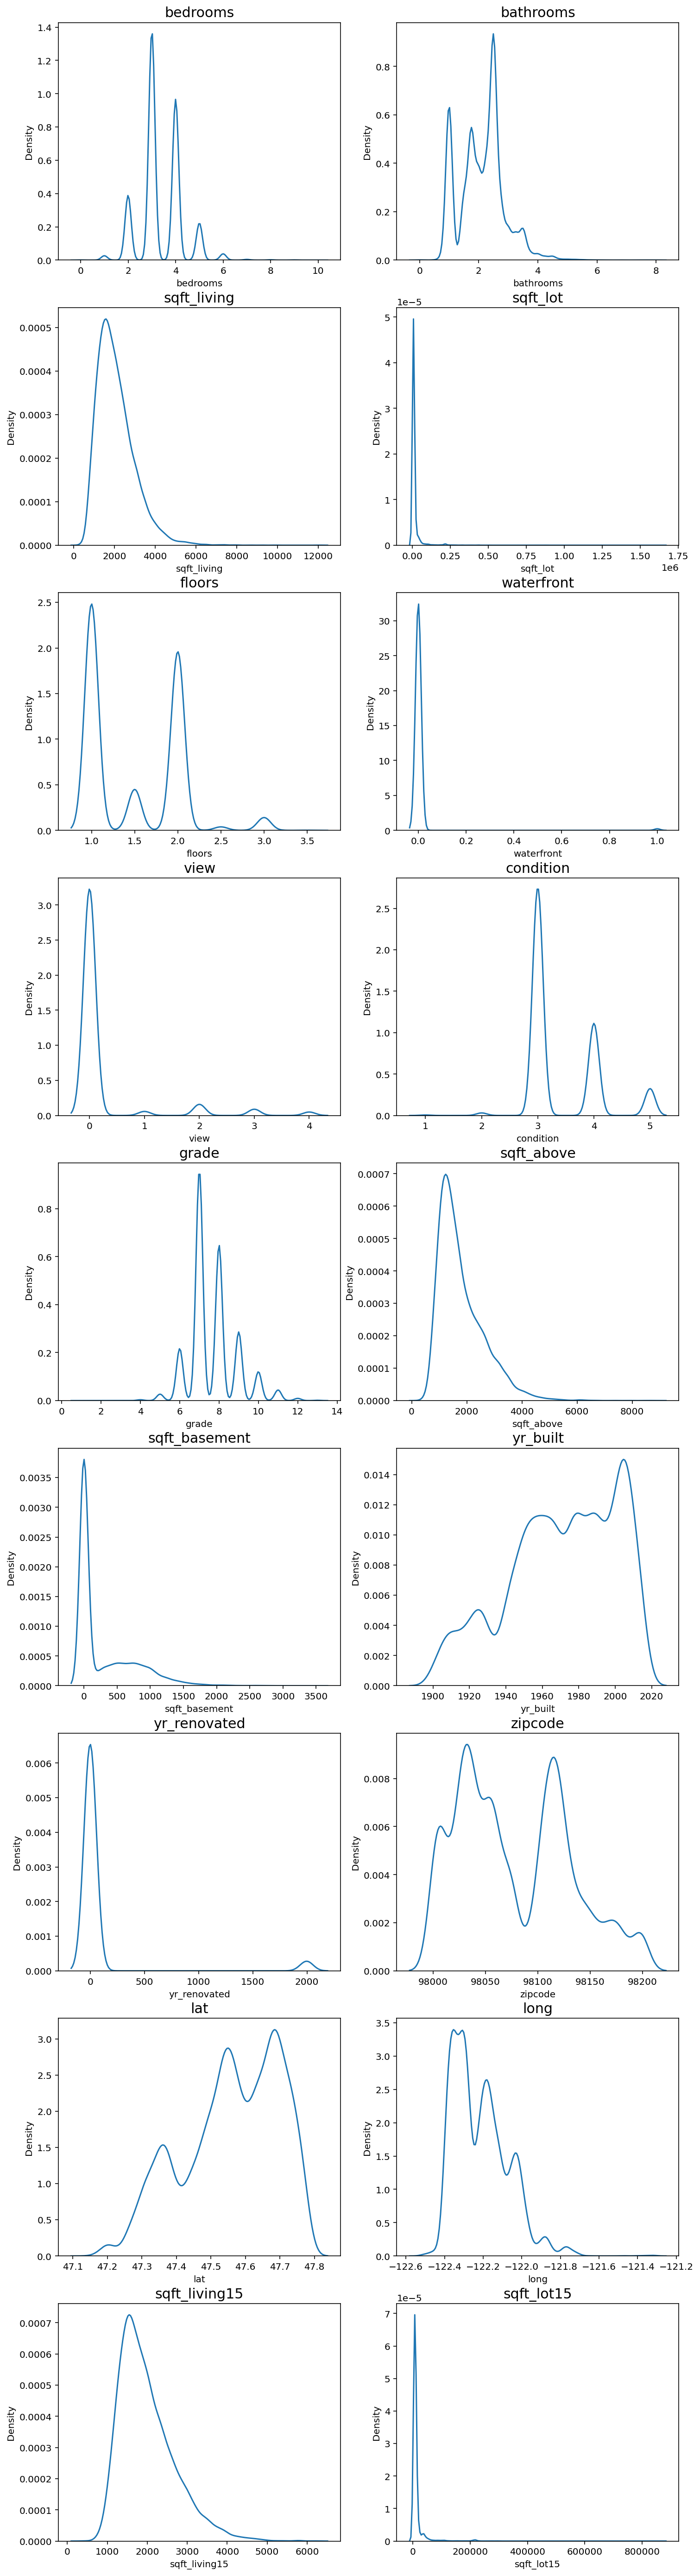

In [27]:
#train 데이터의 변수 별 데이터 분포 확인

fig, ax = plt.subplots(9, 2, figsize=(12, 50))

#date 변수(count==0인 경우)는 제외하고 분포를 확인.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

- 데이터 확인 결과 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15' 칼럼들의 데이터가 정규화가 필요하다고 판단.

In [28]:
#한 쪽으로 치우친 데이터들 정규화

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

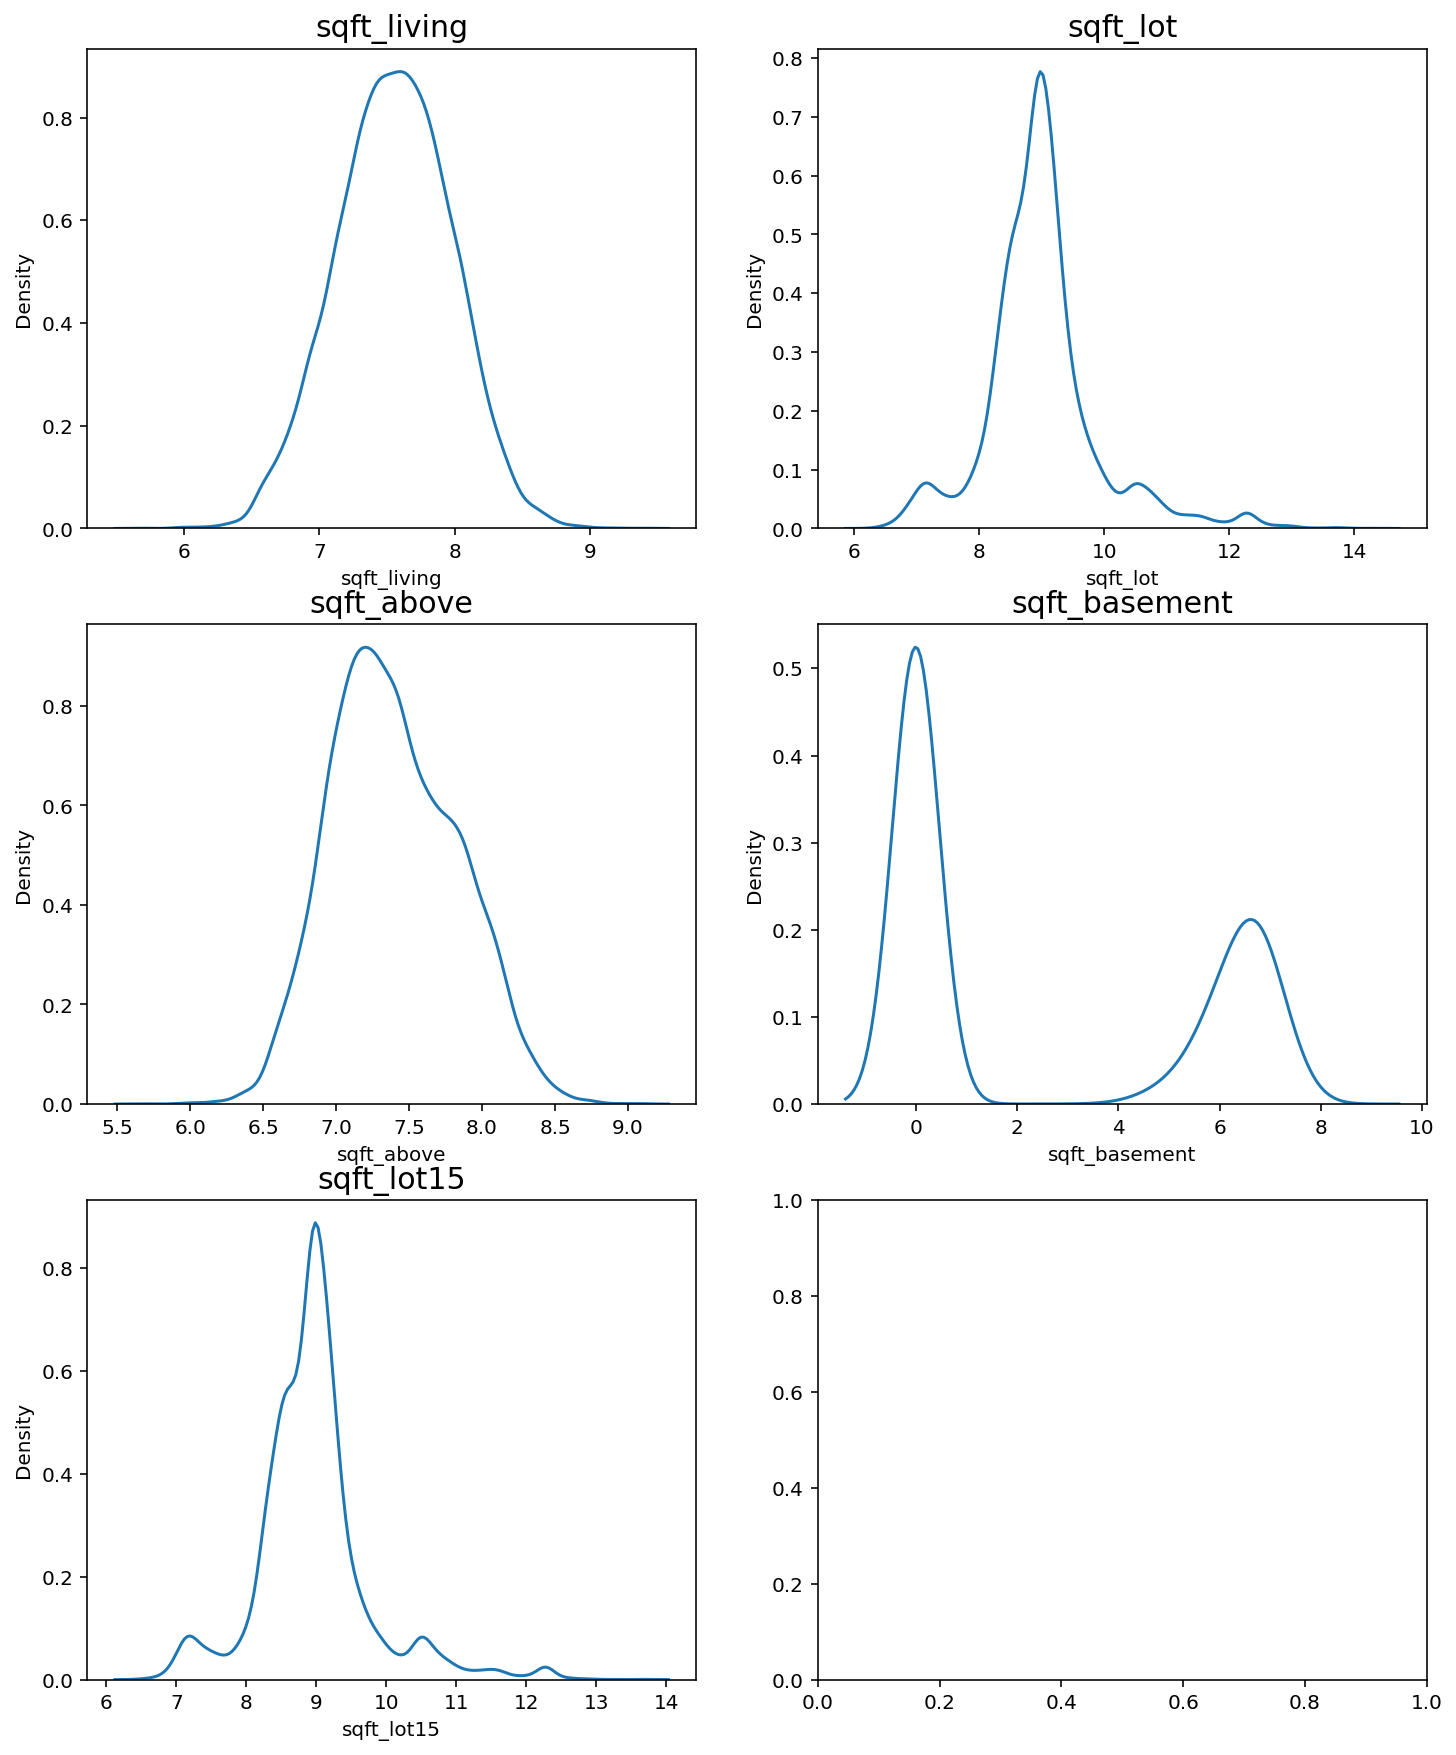

In [29]:
#정규화 되었는지 확인
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [30]:
#전처리한 데이터들 확인
print(train.shape)
print(y.shape)

(15030, 19)
(15030,)


# 3.1 LGBMRegressor 모델

In [31]:
#모델 튜닝

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#RMSE 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [32]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [33]:
#각 모델들의 RMSE 확인
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

RMSE
GradientBoostingRegressor  133240.400808
RandomForestRegressor      127698.688039
XGBRegressor               110966.108243
LGBMRegressor              109536.057064

In [36]:
#grid search 함수
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [37]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.9s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027011  0.164352
2         10            50 -0.029273  0.171095
1          1           100 -0.054972  0.234461
0          1            50 -0.073174  0.270506

- RMSE가 가장 높았던 LGBM모델에 대해서 grid search 진행

In [38]:
#위에서 얻은 최적의 파라미터를 적용하여 모델 학습, 예측 결과하기
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.11377263, 13.04774385, 14.12004333, ..., 13.03966648,
       12.70921534, 12.96480275])

In [39]:
#로그 변환 시킨 데이터들 원래 값으로 되돌리기
prediction = np.expm1(prediction)
prediction

array([ 495722.02308942,  464047.26663342, 1355990.30075639, ...,
        460314.07355047,  330781.17099453,  427111.51074417])

In [40]:
#샘플 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [41]:
#모델이 예측 한 값을 샘플 데이터에 덮어 씌우고 저장
submission['price'] = prediction
submission.head()

id         price
0  15035  4.957220e+05
1  15036  4.640473e+05
2  15037  1.355990e+06
3  15038  3.088406e+05
4  15039  3.311015e+05

In [42]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


- 3.1 LGBMRegressor 모델 결과
![basic_result](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex06/results/basic_result.jpg?raw=true)   
  - 오른쪽이 public score. 
  - grid searh를 진행하여 하이퍼파라미터를 최적으로 설정했지만 LGBM 단일 모델이라 원하는 점수인 110000점 이하로는 나오지 않았다.

---

# 3.2 XGBRegressor 모델
- [링크](https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145)에서 xgboost로 진행한 모델링 과정을 참고함.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import model_selection
import warnings 

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

import os
from os.path import join

In [2]:
#data load

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
#data check
print(train.isnull().sum(), '\n' ,test.isnull().sum(), '\n')
print(train.info(), '\n' ,test.info(), '\n')

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64 
 id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  --

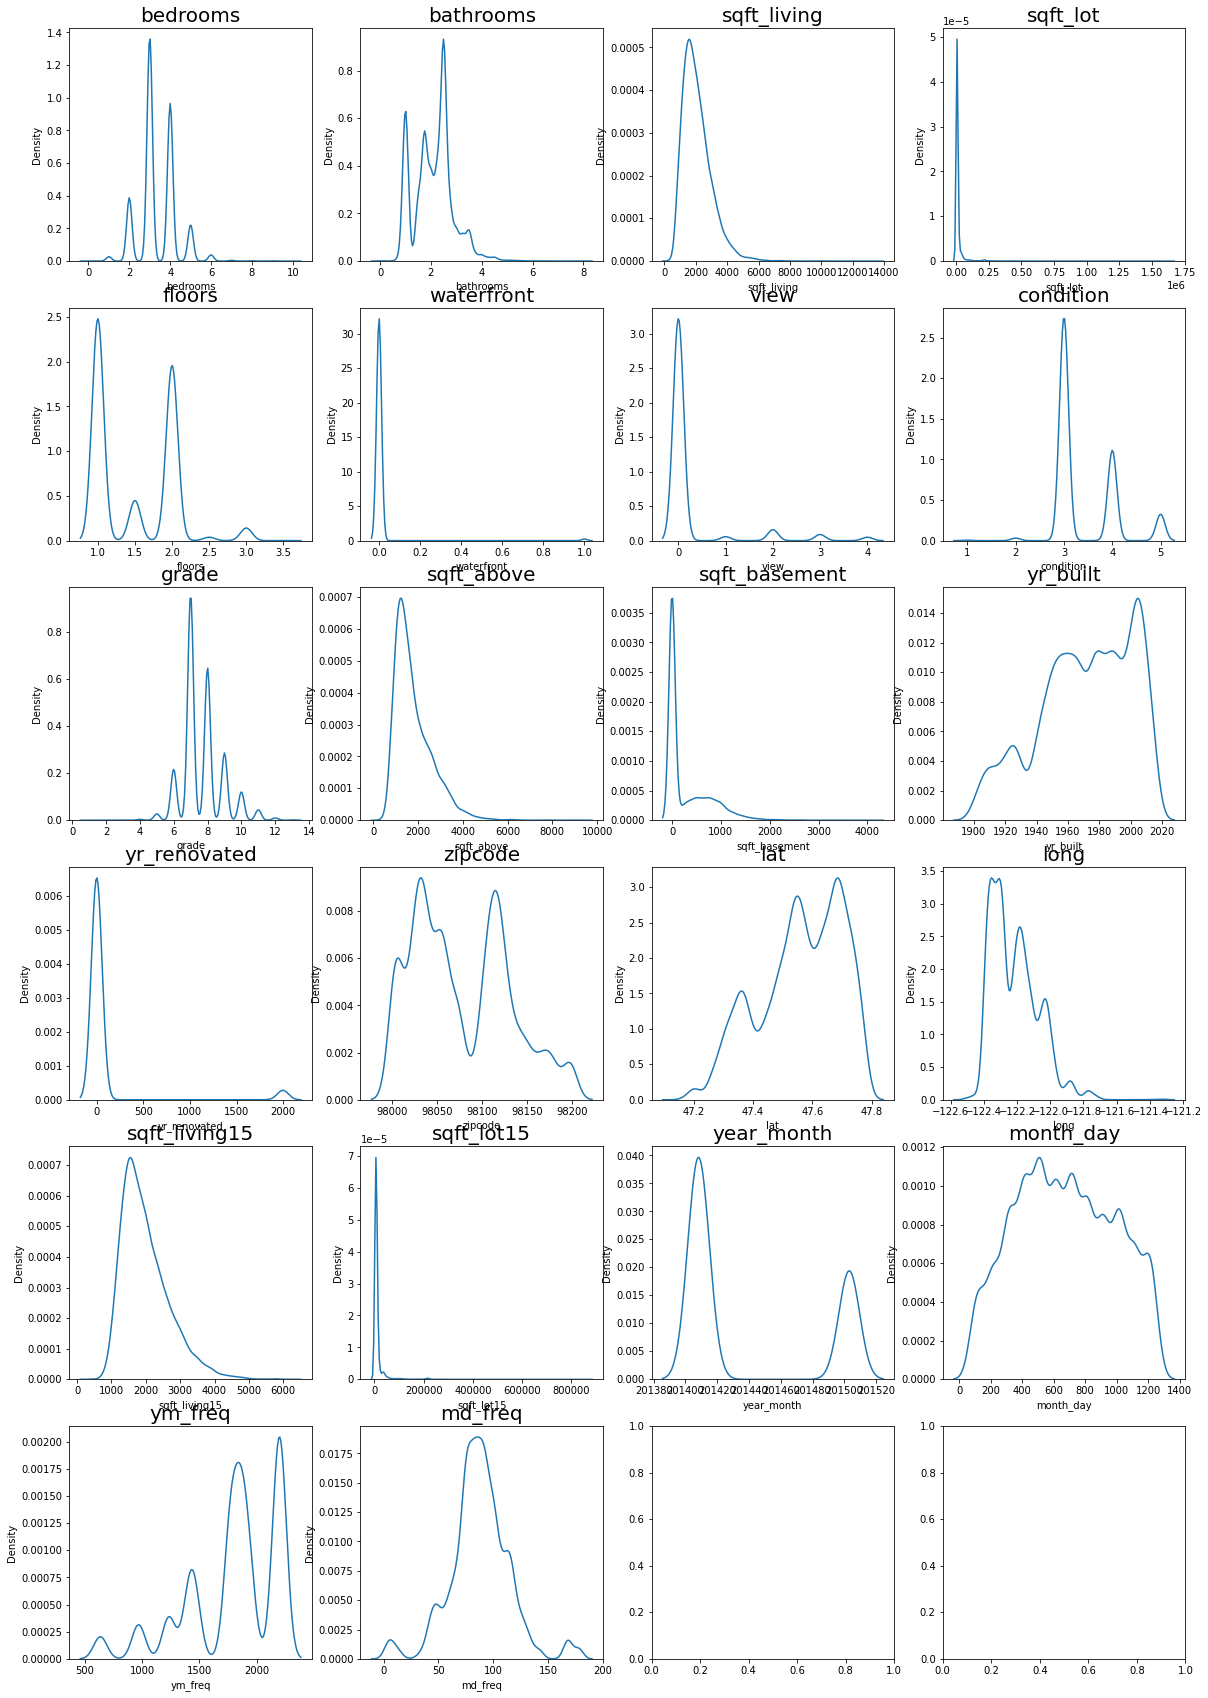

In [4]:
y_train = train.price
x_train = train.drop(['id', 'price'], axis=1)
x_test = test.drop(['id'], axis=1)

index = x_train.shape[0]
df = pd.concat([x_train, x_test], axis=0)
    
year = df.date.apply(lambda x: x[0:4]).astype(int)
month = df.date.apply(lambda x: x[4:6]).astype(int)
day = df.date.apply(lambda x: x[6:8]).astype(int)
    
df['year_month'] = year*100 + month
df['month_day'] = month*100 + day
df['ym_freq'] = df.groupby('year_month')['year_month'].transform('count')
df['md_freq'] = df.groupby('month_day')['month_day'].transform('count')
df = df.drop(['date'], axis=1)

x_train = df.iloc[:index, :]
x_test = df.iloc[index:, :]

x_train.shape, x_test.shape

fig, ax = plt.subplots(6, 4, figsize=(20, 30))
n = 0
cols = x_train.columns
for r in range(6):
    for c in range(4):
        sns.kdeplot(x_train[cols[n]], ax=ax[r][c])
        ax[r][c].set_title(cols[n], fontsize=20)
        n += 1
        if n == x_train.shape[1]:
            break

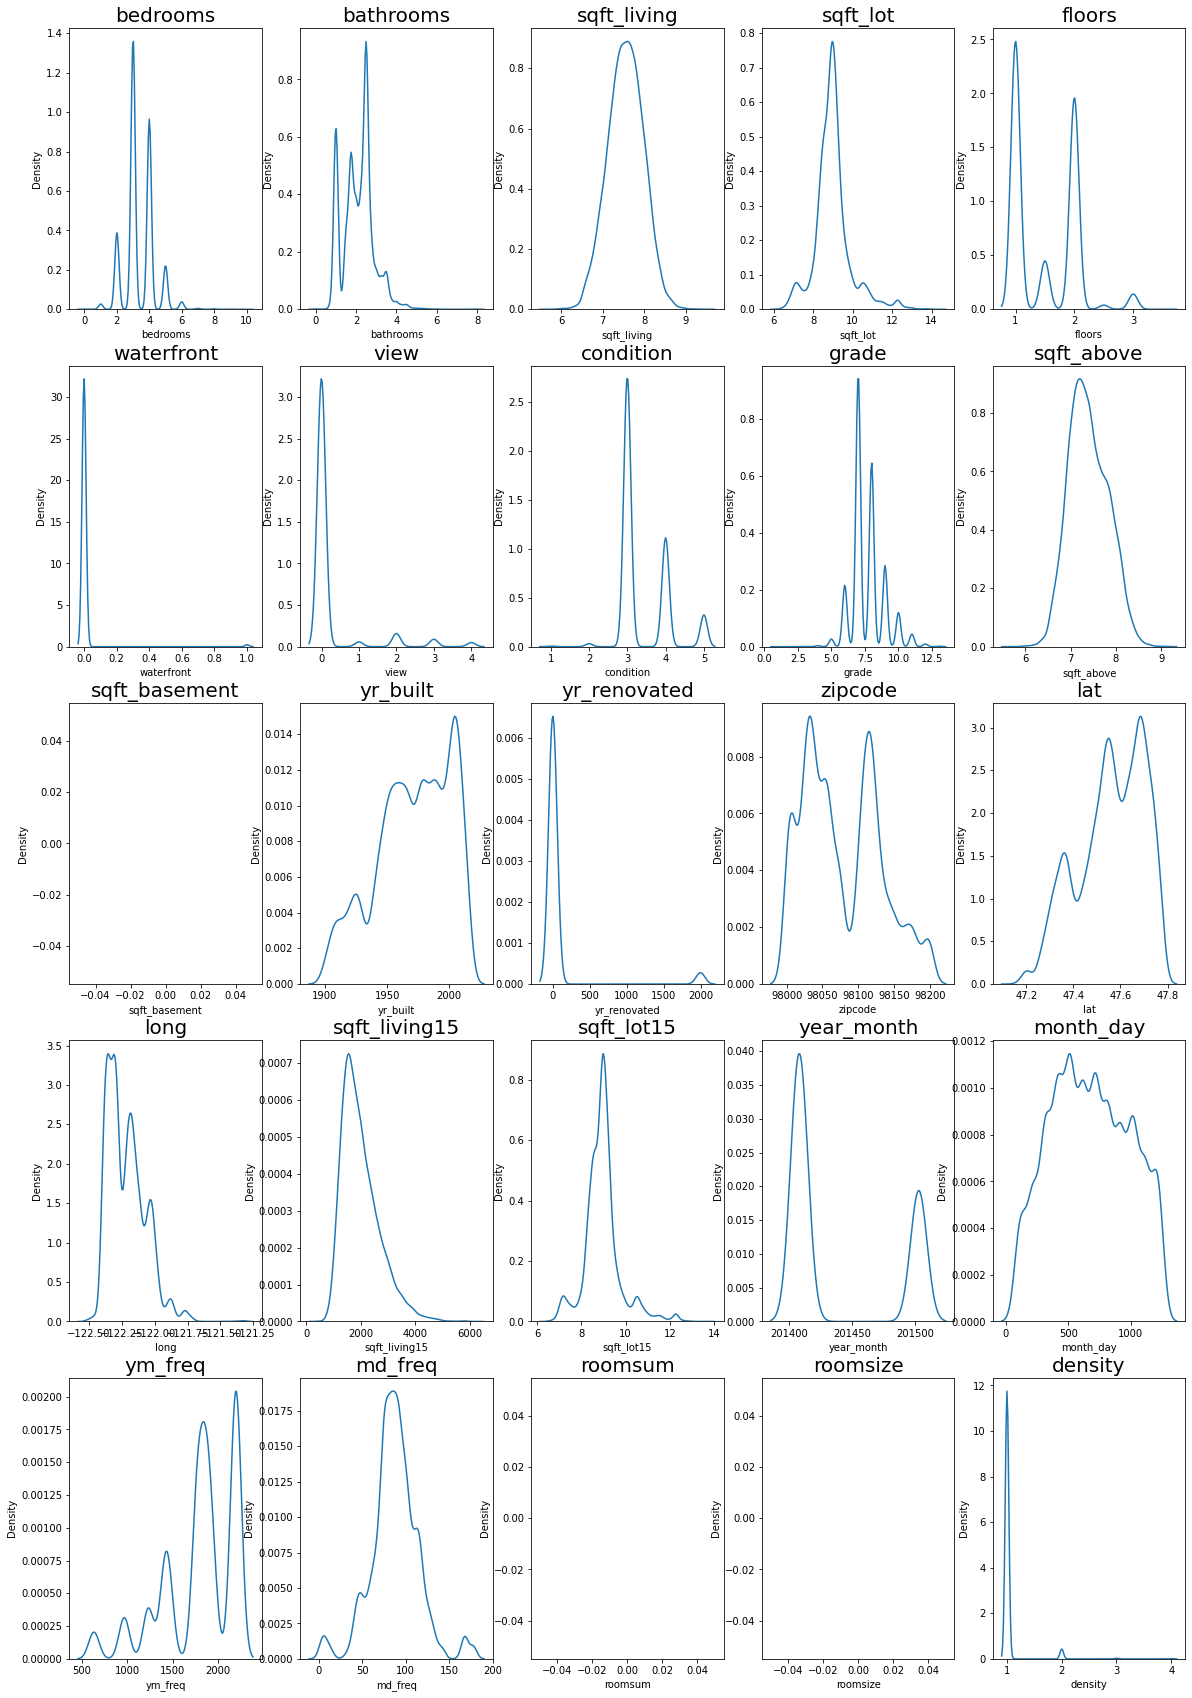

In [5]:
def preprocessing(df):
    
    df.sqft_living = np.log(df.sqft_living)
    df.sqft_lot = np.log(df.sqft_lot)
    df.sqft_above = np.log(df.sqft_above)
    df.sqft_basement = np.log(df.sqft_basement)
    df.sqft_lot15 = np.log(df.sqft_lot15)
    
    df['roomsum'] = np.log(df.bedrooms + df.bathrooms)
    df['roomsize'] = df.sqft_living / df.roomsum
    
    df['pos'] = df.long.astype(str) + ', ' + df.lat.astype(str)
    df['density'] = df.groupby('pos')['pos'].transform('count')
    
    df = df.drop(['pos'], axis=1)
    
    return df

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)

fig, ax = plt.subplots(5, 5, figsize=(20, 30))
n = 0
cols = x_train.columns
for r in range(5):
    for c in range(5):
        sns.kdeplot(x_train[cols[n]], ax=ax[r][c])
        ax[r][c].set_title(cols[n], fontsize=20)
        n += 1
        if n == x_train.shape[1]:
            break

Transform DMatrix...
Start Cross Validation...
[14:14:32] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:14:32] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:14:32] WARNING: ../src/objective/regression_obj.cu:170: reg

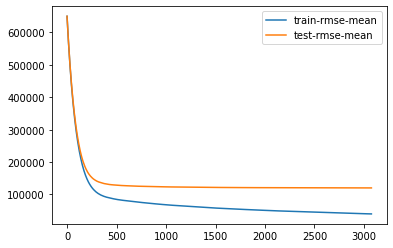

In [6]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

In [8]:
model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

sub = test[['id']]
sub['price'] = preds
sub.to_csv(join(data_dir,'submission_ensemble_3.csv'), index=False)

[14:16:11] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




- 3.2 XGBRegressor 모델 결과
![xgb model rueslt](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex06/results/ensemble_2_result.jpg?raw=true)
  - 오른쪽이 public score.
  -  lgbm 모델보다는 낮은 점수가 나왔지만 역시나 단일 모델 사용이라 110000보다 낮게 나오지는 못했다. 

---

# 3.3 blending
- 전처리 과정은 동일하니 데이터 확인 및 시각화 과정은 생략함.
- 모델 RMSE 순위에서 상위권 두 모델인 lgbm과 xgb 모델을 블렌딩 함.

In [1]:
#필요한 모듈 설치

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#data load

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
#문자가 포함된 date를 정수형으로 변환

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [4]:
#test data 역시 문자가 포함된 date를 정수형으로 변환

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  201412         3       2.25         2570      7242     2.0   
1  15036  201412         4       3.00         1960      5000     1.0   
2  15037  201405         4       4.50         5420    101930     1.0   
3  15038  201504         3       1.00         1780      7470     1.0   
4  15039  201503         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


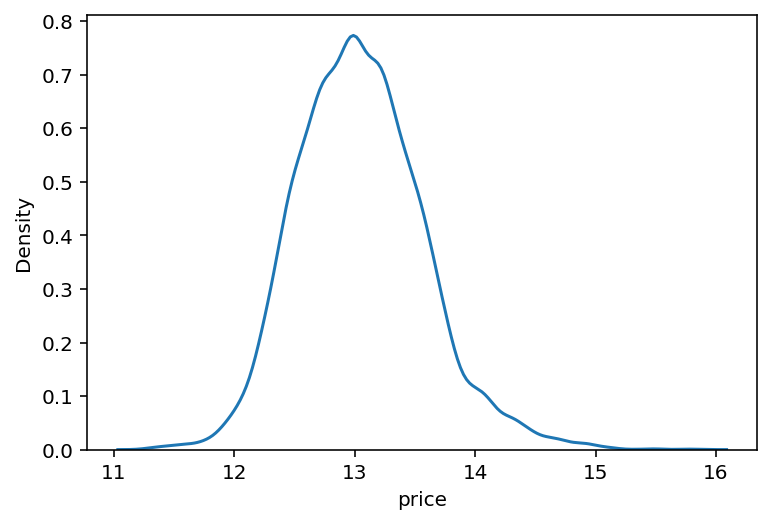

In [5]:
#price 정규화
train['price'] = np.log1p(train['price'])
print(train['price'])

sns.kdeplot(train['price'])
plt.show()

In [6]:
#이상치 제거
train.loc[train['sqft_living'] > 13000]
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

In [7]:
#target에 해당하는 price를 y라는 새로운 변수에 저장 후 삭제

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
#불필요한 'id' 칼럼 삭제
del train['id']

print(train.columns)
train.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3       1.00         1180      5650     1.0           0   
1  201502         2       1.00          770     10000     1.0           0   
2  201502         3       2.00         1680      8080     1.0           0   
3  201406         3       2.25         1715      6819     2.0           0   
4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [9]:
#test data 역시 불필요한 id 칼럼 삭제

del test['id']
print(test.columns)
test.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201412         3       2.25         2570      7242     2.0           0   
1  201412         4       3.00         1960      5000     1.0           0   
2  201405         4       4.50         5420    101930     1.0           0   
3  201504         3       1.00         1780      7470     1.0           0   
4  201503         3       2.50         1890      6560     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        2170            400      1951          1991   
1     0          5      7        1050            910      1965             0   
2     0          3     11        3890           1530      2001             0   
3     0          3      7        1050            730      1960             0   
4     0          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98125  47.7210 -122.319           1690        7639  
1    98136  47.5208 -122.393           1360        5000  
2    98053  47.6561 -122.005           4760      101930  
3    98146  47.5123 -122.337           1780        8113  
4    98038  47.3684 -122.031           2390        7570

In [10]:
#한 쪽으로 치우친 데이터 정규화

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [11]:
#모델 튜닝
#RMSE 계산

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#RMSE 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [12]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [13]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

RMSE
GradientBoostingRegressor  137570.585366
RandomForestRegressor      127648.777301
LGBMRegressor              117171.456190
XGBRegressor               114946.973853

In [14]:
#grid search
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [15]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

lgbm_model = LGBMRegressor(random_state=random_state)
my_GridSearch(lgbm_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.9s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027087  0.164582
2         10            50 -0.029268  0.171079
1          1           100 -0.054992  0.234503
0          1            50 -0.073148  0.270458

In [16]:
#위에서 얻은 최적의 파라미터를 적용하여 모델 학습, 예측 결과하기
lgbm_model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
lgbm_model.fit(train, y)
lgbm_prediction = lgbm_model.predict(test)
lgbm_prediction

array([13.12595081, 13.03987182, 14.13197677, ..., 13.05123759,
       12.68004921, 12.97692047])

In [17]:
#로그 변환 시킨 데이터들 원래 값으로 되돌리기
lgbm_prediction = np.expm1(lgbm_prediction)
lgbm_prediction

array([ 501795.93643132,  460408.60689881, 1372268.8716153 , ...,
        465671.36477551,  321272.8683469 ,  432318.626863  ])

In [18]:
xgb_model = XGBRegressor(random_state=random_state)
my_GridSearch(xgb_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  5.6min finished


max_depth  n_estimators     score     RMSLE
2         10            50 -0.030713  0.175252
3         10           100 -0.031001  0.176071
1          1           100 -0.042998  0.207361
0          1            50 -0.048737  0.220764

In [19]:
#위에서 얻은 최적의 파라미터를 적용하여 모델 학습, 예측 결과하기
xgb_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
xgb_model.fit(train, y)
xgb_prediction = xgb_model.predict(test)
xgb_prediction

array([13.145901 , 13.0445   , 14.013298 , ..., 13.0796175, 12.667063 ,
       13.024597 ], dtype=float32)

In [20]:
#로그 변환 시킨 데이터들 원래 값으로 되돌리기
xgb_prediction = np.expm1(xgb_prediction)
xgb_prediction

array([ 511907.28,  462544.56, 1218702.4 , ...,  479076.44,  317127.62,
        453429.44], dtype=float32)

In [21]:
#ensemble
ensemble_pred = np.vstack([lgbm_prediction, xgb_prediction]).mean(0)
ensemble_pred

array([ 506851.60884066,  461476.58469941, 1295485.62330765, ...,
        472373.90113776,  319200.24667345,  442874.0321815 ])

In [22]:
#샘플데이터 로드
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [23]:
#모델이 예측 한 값을 샘플 데이터에 덮어 씌우고 저장
submission['price'] = ensemble_pred
submission.head()

id         price
0  15035  5.068516e+05
1  15036  4.614766e+05
2  15037  1.295486e+06
3  15038  3.189384e+05
4  15039  3.341980e+05

In [24]:
submission.to_csv(join(data_dir,"submission_ensemble_6.csv"),index=False)

- 3.3 blending 결과
![result](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex06/results/ensemble_5_result.jpg?raw=true)
  - 오른쪽이 public score.
  - 위에서 사용했던 lgbm 모델과 xgb 모델을 앙상블하였지만 점수가 오히려 더 높아졌음. 
  - 제대로 된 앙상블 방법이 아니라고 판단하여 다른 커널들에서 사용한 앙상블 코드를 보고 학습함.

# 3.4 stacking ensemble
- [링크](https://techblog-history-younghunjo1.tistory.com/103)를 참조하여 CV를 적용한 stacking 함수를 사용했음.
- 마찬가지로 데이터 전처리 과정은 동일하기 때문에 데이터 확인 및 시각화 과정은 하지 않음.

In [1]:
#필요한 모듈 설치

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#data load

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [2]:
#문자가 포함된 date를 정수형으로 변환

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [3]:
#test data 역시 문자가 포함된 date를 정수형으로 변환

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  201412         3       2.25         2570      7242     2.0   
1  15036  201412         4       3.00         1960      5000     1.0   
2  15037  201405         4       4.50         5420    101930     1.0   
3  15038  201504         3       1.00         1780      7470     1.0   
4  15039  201503         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


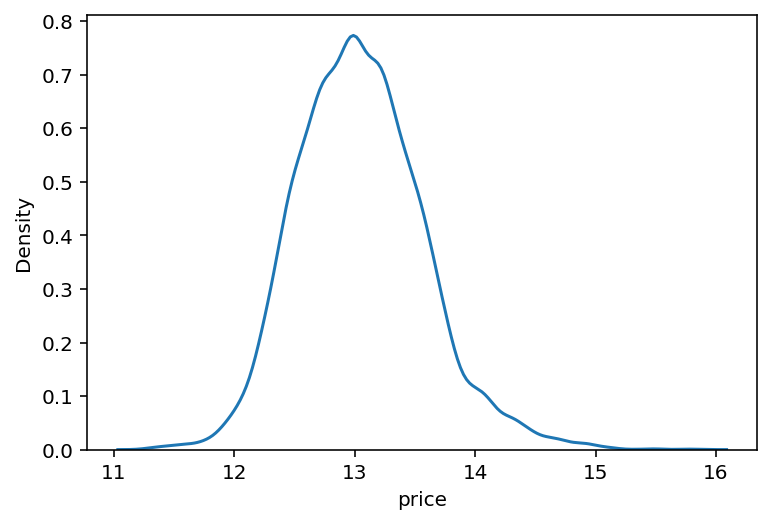

In [4]:
#price 정규화
train['price'] = np.log1p(train['price'])
print(train['price'])

sns.kdeplot(train['price'])
plt.show()

In [5]:
#이상치 제거
train = train.loc[train['id']!=8912]
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

In [6]:
#target에 해당하는 price를 y라는 새로운 변수에 저장 후 삭제

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
del train['id']

print(train.columns)
train.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3       1.00         1180      5650     1.0           0   
1  201502         2       1.00          770     10000     1.0           0   
2  201502         3       2.00         1680      8080     1.0           0   
3  201406         3       2.25         1715      6819     2.0           0   
4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [8]:
#test data 역시 불필요한 id 칼럼 삭제

del test['id']
print(test.columns)
test.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201412         3       2.25         2570      7242     2.0           0   
1  201412         4       3.00         1960      5000     1.0           0   
2  201405         4       4.50         5420    101930     1.0           0   
3  201504         3       1.00         1780      7470     1.0           0   
4  201503         3       2.50         1890      6560     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        2170            400      1951          1991   
1     0          5      7        1050            910      1965             0   
2     0          3     11        3890           1530      2001             0   
3     0          3      7        1050            730      1960             0   
4     0          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98125  47.7210 -122.319           1690        7639  
1    98136  47.5208 -122.393           1360        5000  
2    98053  47.6561 -122.005           4760      101930  
3    98146  47.5123 -122.337           1780        8113  
4    98038  47.3684 -122.031           2390        7570

In [9]:
#한 쪽으로 치우친 데이터 정규화

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [10]:
#dataset 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state = 0)

In [11]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(12024, 19) (3006, 19)
(12024,) (3006,)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

In [13]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')

# 개별모델 내부에서 CV 적용해 Stacking하는 함수 구현
def get_stacking_datasets(model, x_train_n, y_train_n, x_test_n, n_folds):
    # CV하기 위해 K-fold 설정
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=42)
    
    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((x_train_n.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((x_test_n.shape[0], n_folds))
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(kf.split(x_train_n)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        x_tr = x_train_n.reindex(train_idx, fill_value=0)
        y_tr = y_train_n.reindex(train_idx, fill_value=0)
        x_te = x_train_n.reindex(valid_idx, fill_value=0)
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(x_tr, y_tr)
        train_fold_pred[valid_idx, :] = model.predict(x_te).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(x_test_n)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [15]:
gb_train, gb_test = get_stacking_datasets(gboost, X_train, y_train, X_test, 5)

GradientBoostingRegressor 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5


In [16]:
rd_train, rd_test= get_stacking_datasets(rdforest, X_train, y_train, X_test, 5)

RandomForestRegressor 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5


In [17]:
xg_train, xg_test= get_stacking_datasets(xgboost, X_train, y_train, X_test, 5)

XGBRegressor 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5


In [18]:
# 개별모델이 생성한 학습/검증 데이터 최종 메타 모델이 학습/검증하도록 결합
stack_final_x_train = np.concatenate((gb_train, rd_train, xg_train), axis=1)
stack_final_x_test = np.concatenate((gb_test, rd_test, xg_test), axis=1)

# 최종 메타모델로 학습
# 최종 메타모델 학습시 label은 원본 데이터의 label(y값)
lightgbm.fit(stack_final_x_train, y_train)
stack_final_pred = lightgbm.predict(stack_final_x_test)

In [19]:
stack_final_pred

array([13.01471317, 13.04399599, 13.05072995, ..., 13.02190087,
       13.1568021 , 13.12527737])

In [20]:
#로그변환 했던 값들 다시 되돌림.

stack_final_pred = np.expm1(stack_final_pred)
stack_final_pred

array([448969.81684383, 462311.33547071, 465435.03324389, ...,
       452208.51008423, 517518.3012692 , 501458.12023433])

In [21]:
#샘플 데이터 가져옴
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [22]:
#샘플 데이터에 예측값 넣음
submission['price'] = pd.Series(stack_final_pred)
print(submission.shape)
submission.head()

(6468, 2)


id          price
0  15035  448969.816844
1  15036  462311.335471
2  15037  465435.033244
3  15038  472842.574964
4  15039  483362.046360

In [23]:
#nan 값 제거
submission = submission.dropna()

In [24]:
submission.to_csv(join(data_dir,"submission_ensemble_5.csv"),index=False)

- 3.4 stacking ensemble 결과
![결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex06/results/ensemble_4_result.jpg?raw=true)
  - 최종 모델 학습 후 실제 test 데이터를 적용하지 못하는 문제가 생김.
  - 학습 시킨 데이터의 shape와 실제 test 데이터의 shape가 일치하지 않음.
  - 실제 test 데이터가 아니라 stack_final_pred 예측 값을 넣으면 결과 파일의 길이가 nan값 제거로 달라짐.
  - 결과 파일의 사이즈가 제출해야 하는 6468과 맞지 않아 결과를 제출하면 에러가 뜸.

# 3.5 xgb, lgbm ensemble  
- [링크](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)를 참조하여 데이터 전처리 및 ensemble 진행함.

In [1]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import os
from os.path import join

#data load

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

print(df_train.shape)
print(df_test.shape)

(15035, 21)
(6468, 20)


In [2]:
df_train.head()


id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [3]:
#descriptive statistics summary
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

### - 데이터 확인 및 전처리

<AxesSubplot:xlabel='price', ylabel='Density'>

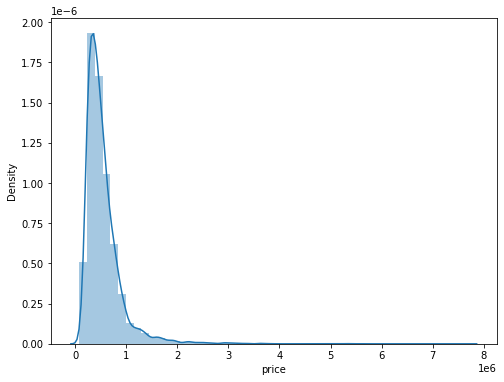

In [4]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [5]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


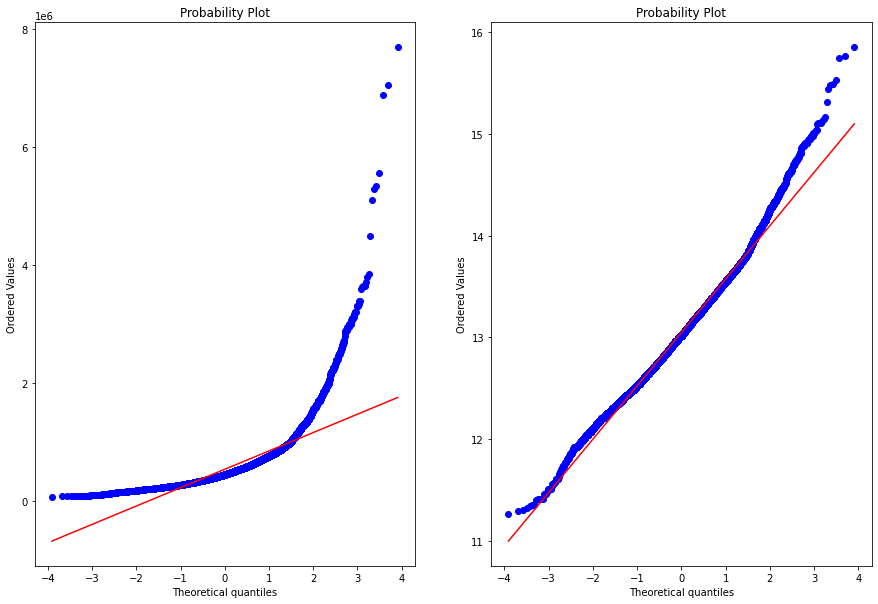

In [6]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

<AxesSubplot:xlabel='price', ylabel='Density'>

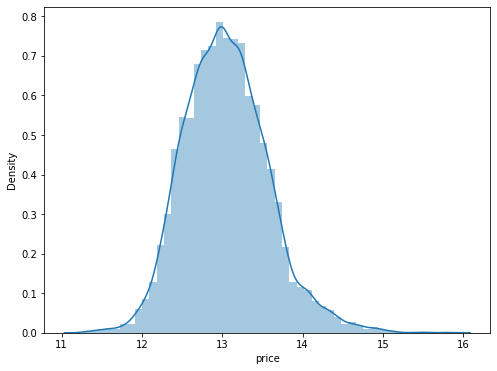

In [7]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

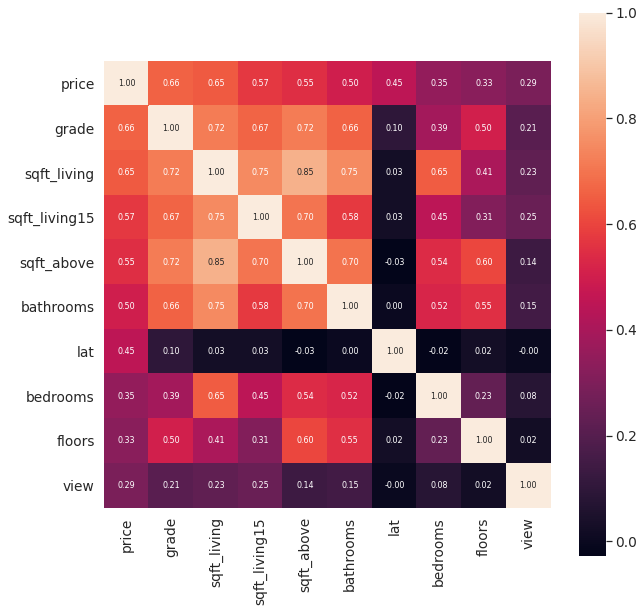

In [8]:
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

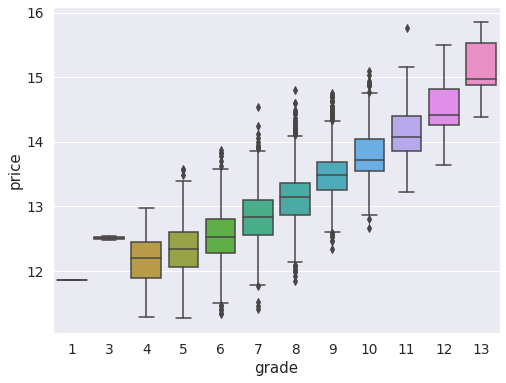

In [9]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

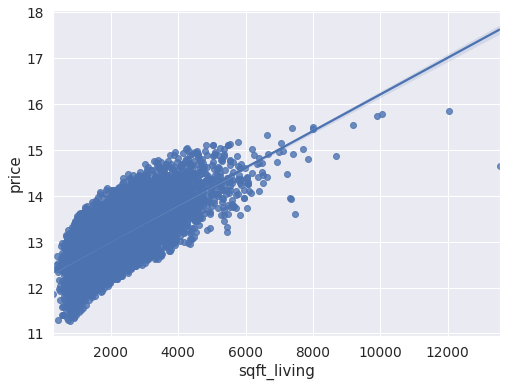

In [10]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

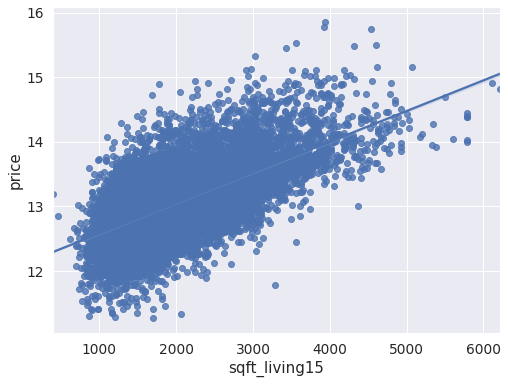

In [11]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

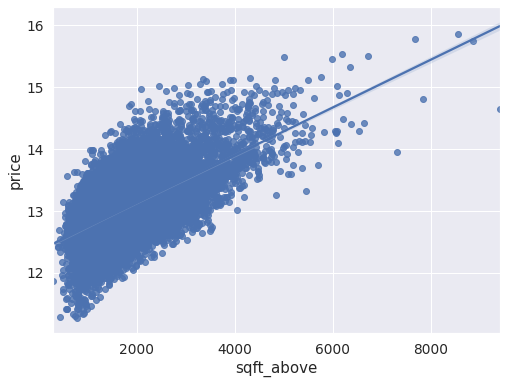

In [12]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

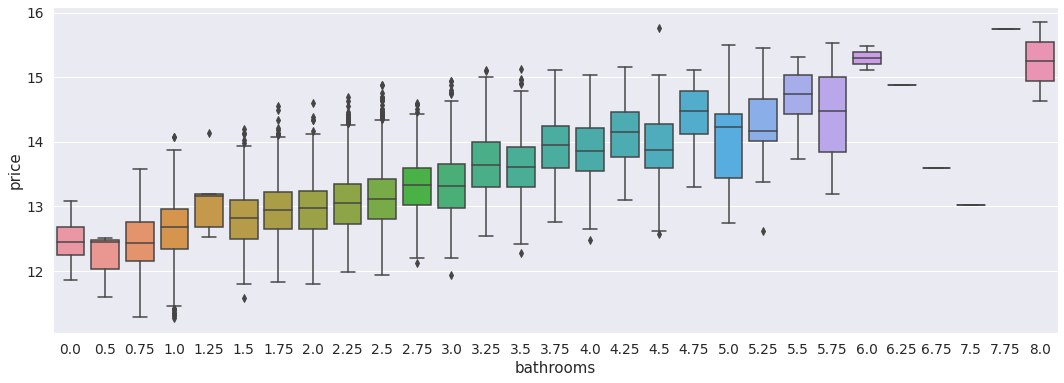

In [13]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

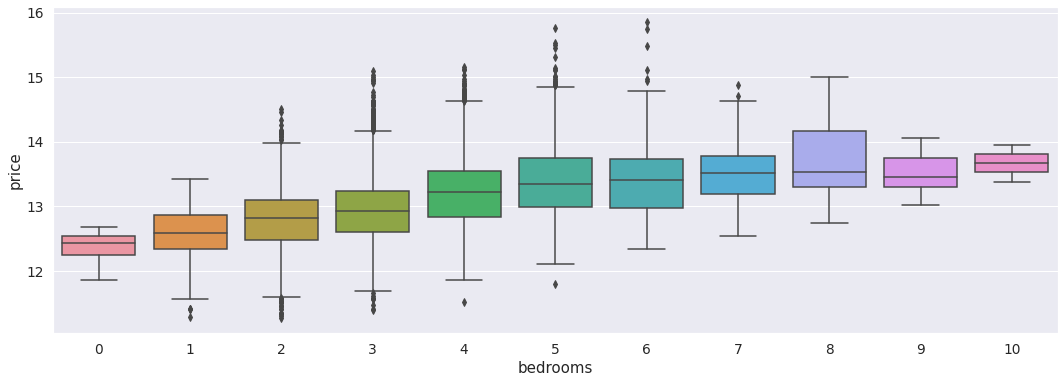

In [14]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

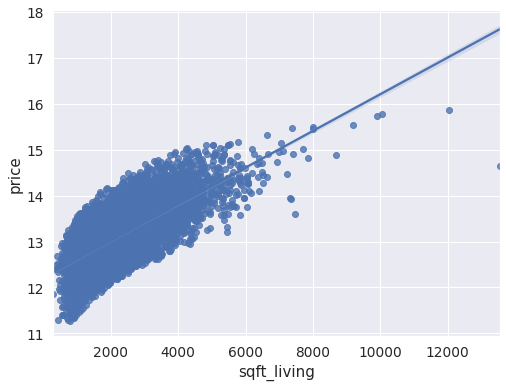

In [15]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [16]:
#결측치 확인 및 제거
df_train.loc[df_train['sqft_living'] > 13000]

id             date      price  bedrooms  bathrooms  sqft_living  \
8912  8912  20140505T000000  14.639686         7        8.0        13540   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
8912    307752     3.0           0     4  ...     12        9410   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
8912           4130      1999             0    98053  47.6675 -121.986   

      sqft_living15  sqft_lot15  
8912           4850      217800  

[1 rows x 21 columns]

In [17]:
df_train = df_train.loc[df_train['id']!=8990]

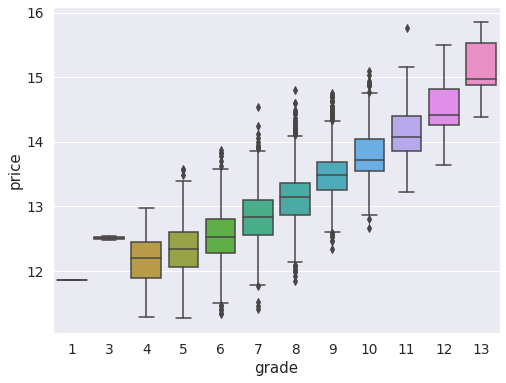

In [18]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [19]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

id             date      price  bedrooms  bathrooms  sqft_living  \
2302  2302  20150225T000000  12.476104         1       0.75          520   
4123  4123  20141104T000000  12.542548         1       0.00          600   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
2302     12981     1.0           0     0  ...      3         520   
4123     24501     1.0           0     0  ...      3         600   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
2302              0      1920             0    98022  47.2082 -121.995   
4123              0      1950             0    98045  47.5316 -121.749   

      sqft_living15  sqft_lot15  
2302           1340       12233  
4123            990       22549  

[2 rows x 21 columns]

In [20]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

id             date      price  bedrooms  bathrooms  sqft_living  \
7173  7173  20140813T000000  14.808763         5        4.0         4230   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
7173     27295     2.0           1     4  ...      8        3230   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
7173           1000      1949          1985    98033  47.6803 -122.214   

      sqft_living15  sqft_lot15  
7173           2660       27295  

[1 rows x 21 columns]

In [21]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

id             date     price  bedrooms  bathrooms  sqft_living  \
2775  2775  20140611T000000  15.77031         5        4.5        10040   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
2775     37325     2.0           1     2  ...     11        7680   

      sqft_basement  yr_built  yr_renovated  zipcode    lat     long  \
2775           2360      1940          2001    98004  47.65 -122.214   

      sqft_living15  sqft_lot15  
2775           3930       25449  

[1 rows x 21 columns]

In [22]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

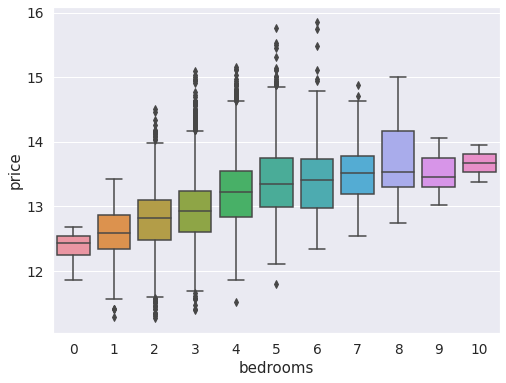

In [23]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [24]:
#데이터 정규화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [25]:
#변수 생성
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [26]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [27]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [28]:
df_train.head()

id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013  12.309987         3       1.00     7.074117  8.639588   
1   1  20150225  12.100718         2       1.00     6.647688  9.210440   
2   2  20150218  13.142168         3       2.00     7.427144  8.997271   
3   3  20140627  12.458779         3       2.25     7.447751  8.827615   
4   4  20150115  12.583999         3       1.50     6.966967  9.181118   

   floors  waterfront  view  ...  sqft_lot15  total_rooms  sqft_ratio  \
0     1.0           0     0  ...        5650         4.00    0.818803   
1     1.0           0     0  ...        8062         3.00    0.721756   
2     1.0           0     0  ...        7503         5.00    0.825489   
3     2.0           0     0  ...        6819         5.25    0.843688   
4     1.0           0     0  ...        9711         4.50    0.758837   

   sqft_total_size  sqft_ratio_1  sqft_ratio15  is_renovated  per_price  \
0         7.074117           1.0      0.237168             0   1.740145   
1         6.647688           1.0      0.337385             0   1.820290   
2         7.427144           1.0      0.239904             0   1.769478   
3         7.447751           1.0      0.328201             0   1.672824   
4         6.966967           1.0      0.169910             0   1.806238   

   zipcode_mean  zipcode_var  
0      9.368147     1.214207  
1      9.257745     1.023549  
2     11.307711     0.826257  
3     10.626177     1.012780  
4     10.032009     1.002206  

[5 rows x 30 columns]

### - 모델링

####   - 단순 선형 회귀

In [29]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.746e+06
Date:                Sat, 31 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:52:50   Log-Likelihood:                         -7.7075
No. Observations:               15029   AIC:                                      65.42
Df Residuals:                   15004   BIC:                                      255.9
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

Features    VIF Values
23  sqft_total_size           inf
21      total_rooms           inf
3          bedrooms           inf
4         bathrooms           inf
13    sqft_basement           inf
12       sqft_above           inf
16          zipcode  5.294167e+06
1              date  4.284045e+06
18             long  2.057338e+06
17              lat  2.441371e+05
15     yr_renovated  1.710401e+05
14         yr_built  1.643116e+05
5       sqft_living  5.751059e+04
24     sqft_ratio_1  3.388901e+04
2             price  1.680872e+04
27        per_price  1.415339e+04
22       sqft_ratio  1.119058e+04
6          sqft_lot  8.614322e+03
28     zipcode_mean  4.158839e+02
11            grade  1.706947e+02
29      zipcode_var  6.274545e+01
10        condition  3.731152e+01
19    sqft_living15  3.202767e+01
7            floors  2.681727e+01
25     sqft_ratio15  1.326763e+01
26     is_renovated  6.638729e+00
0                id  4.317358e+00
20       sqft_lot15  2.876344e+00
9              view  1.618627e+00
8        waterfront  1.232222e+00

- 각각의 변수들 중에서는 p-value가 높은 값들이 있음을 확인할 수 있음.다중공선성을 체크하기 위해 vif를 이용한 확인함.
- 보통의 경우 10 이상이면 다중공선성이 존재한다고 말하는데, 위의 식에서는 waterfront, view, sqft_lot15, is_renovated 4가지 변수를 제외한 모든 변수들에서 다중공선성이 존재하는 문제점이 있음.
- 이를 해결하기 위해 다중공선성에 robust한 트리모델을 사용하는 방법을 사용함.

####  - LightGBM

In [32]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.140092	valid_1's rmse: 0.156519
[1000]	training's rmse: 0.121221	valid_1's rmse: 0.153075
[1500]	training's rmse: 0.108602	valid_1's rmse: 0.152351
Early stopping, best iteration is:
[1505]	training's rmse: 0.108489	valid_1's rmse: 0.152332
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139304	valid_1's rmse: 0.159886
[1000]	training's rmse: 0.120849	valid_1's rmse: 0.155975
[1500]	training's rmse: 0.108283	valid_1's rmse: 0.154827
[2000]	training's rmse: 0.0982398	valid_1's rmse: 0.154545
Early stopping, best iteration is:
[2130]	training's rmse: 0.0959464	valid_1's rmse: 0.154486
[LightGBM] [Warning] min_data_in_leaf is

In [33]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115960.42942127095


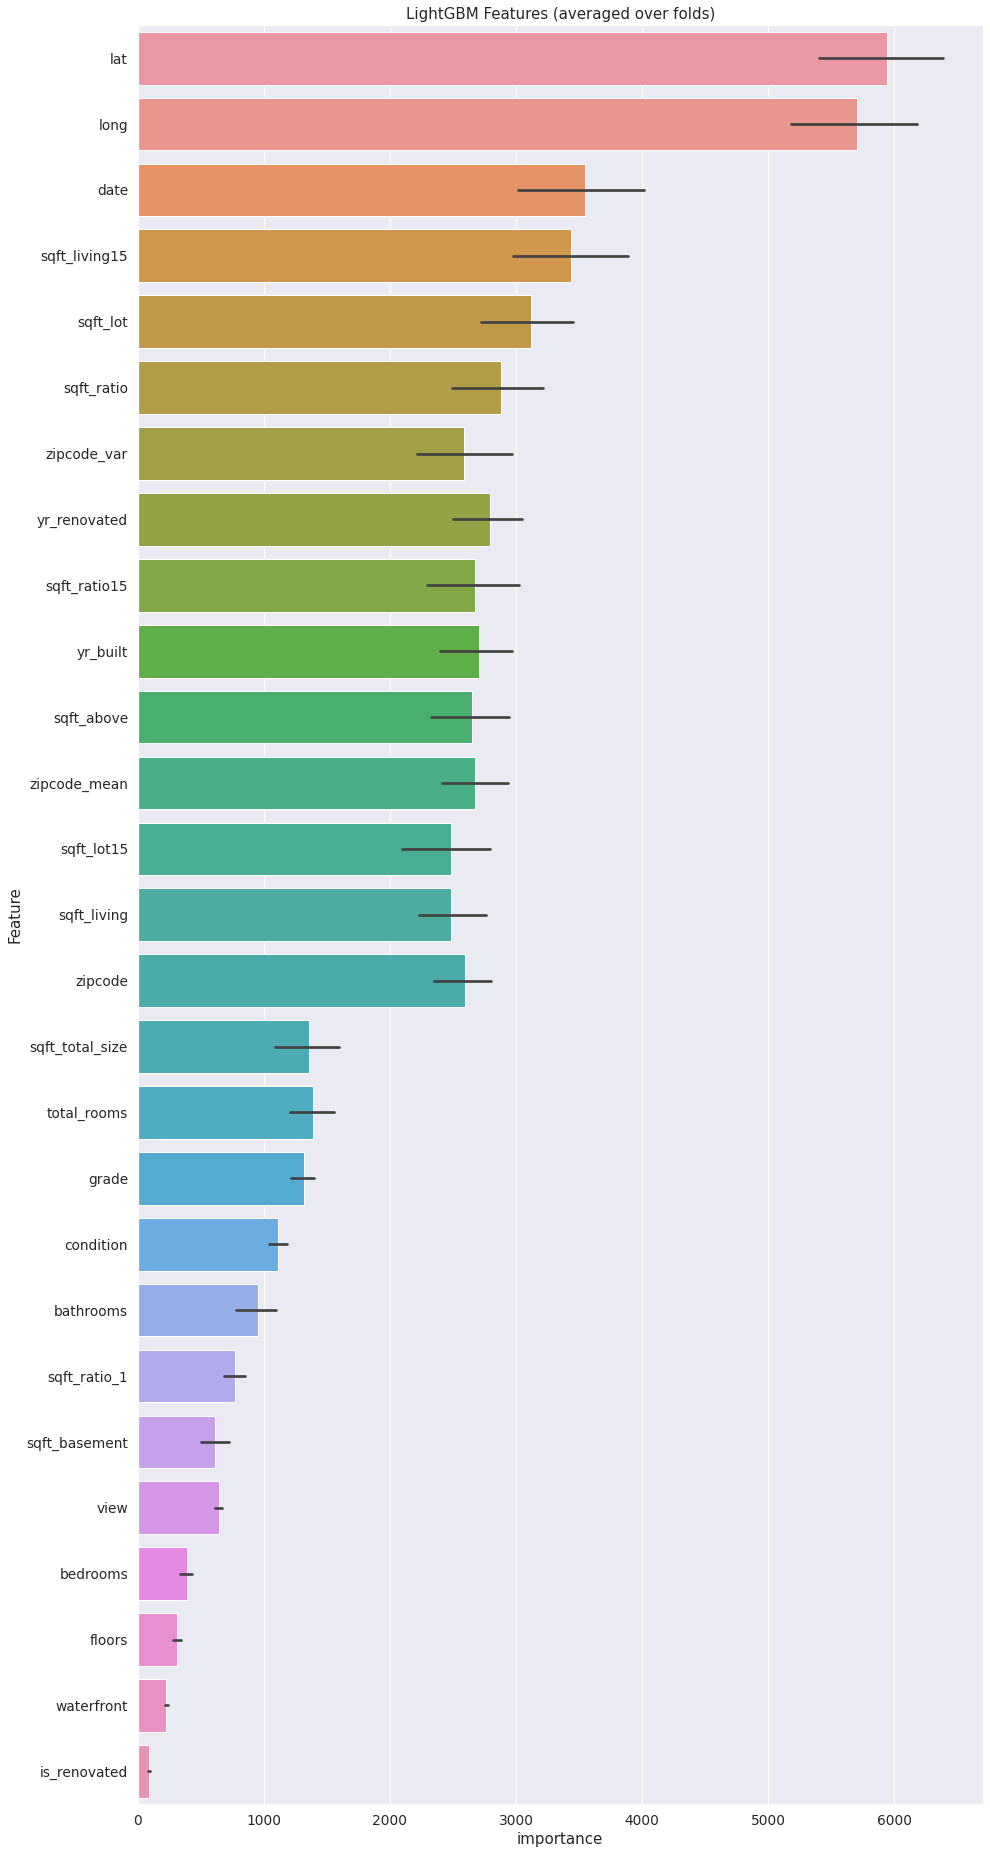

In [34]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [35]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115960.42942127095


In [36]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135526	valid_1's rmse: 134961
[1000]	training's rmse: 110615	valid_1's rmse: 123725
[1500]	training's rmse: 99530.7	valid_1's rmse: 121525
[2000]	training's rmse: 91409.6	valid_1's rmse: 121040
Early stopping, best iteration is:
[2067]	training's rmse: 90494.9	valid_1's rmse: 120880
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135171	valid_1's rmse: 134731
[1000]	training's rmse: 110537	valid_1's rmse: 117358
[1500]	training's rmse: 100159	valid_1's rmse: 114319
Early stopping, best iteration is:
[1845]	training's rmse: 94511.6	valid_1's rmse: 113898
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will

In [37]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

124996.83409814813


#### - xgboost

In [38]:
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[14:58:30] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:30] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:58:30] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:30] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:58:30] WARNING: ../src/objective/regression_obj.cu:170: reg

In [39]:
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[15:00:28] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:28] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:00:28] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:28] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:00:28] WARNING: ../src/objective/regression_obj.cu:170: reg

In [40]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

115824.77593122724


In [41]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [42]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [43]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]

In [44]:
ensemble_sub.to_csv(join(data_dir,"submission_ensemble_4.csv"),index=False)

- 3.5 xgb, lgbm ensemble 결과
![결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex06/results/ensemble_3_result.jpg?raw=true)
  - 오른쪽이 public score.
  - 전처리 과정,  ensemble 과정 모두 거쳐 110000보다 낮은 점수를 얻을 수 있었다.

---

# 4. 프로젝트 정리
---   
1. 두 개의 모델을 사용하는 것이 단일 모델만 사용하는 것보다 더 좋을 수도 있지만 데이터 전처리가 제대로 진행되지 않으면 단일 모델만 사용하는 것 보다 못할 수도 있다는 것을 알게 되었다.   
2. 스태킹 앙상블을 사용하고 싶었으나 스킬 부족으로 제대로 된 결과를 얻을 수 없었다. 조금 더 공부해서 스태킹 앙상블을 활용하여 1차 해커톤도 참여하면 좋을 것 같다.
3. 캐글 상위 커널을 보면서 데이터 시각화, 전처리 과정을 다양하게 할 수 있다는 것을 알 수 있었고 앙상블을 어떻게 하는지도 배울 수 있었다.   
## 느낀점
- 많이 부족하고 배울 것도 많으며 기술적으로도 익혀야 할 것이 많다는 것을 깨닫게 된 프로젝트였다.
- lms 개념 노드나 구글링을 통한 개념을 공부하는 것도 중요하지만 직접 코드를 보며 따라하는 것 또한 큰 도움이 된다는 것을 알게 되었다. 
- 어영부영 점수를 낮출 수 있었지만 다음에는 스스로의 힘으로 이루어 낼 수 있었으면 좋겠다.